## PLS-DA section (and overall the end part of the notebook) needs some refining to be coherent with other sections - next commit

### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with the following peak alignment: 
#### 1st alignment: min_sample = 6 - NAME: 1-6
#### 2nd alignment: min_sample = 13 - NAME: 1-13 or 2 - Name: 1-2

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py, multianalysis.py where they are better described and try to say what is happening in each block of code.

## Similarity analysis - "True" Non Bias

aligned_all_neg = negative dataset alignment 1-6 / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 1-6 / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 1-2 or 1-13 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 1-2 or 1-13 / aligned_pos2 - binary matrix equivalent

#### Read aligned data

In [3]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    bc = pd.read_csv(filename, header = [0,1], index_col = [0])
    bc.columns = mi
    return bc

In [4]:
aligned_all_pos = read_aligned_files('aligned_1ppm_min6_1ppm_positive.csv')
aligned_all_neg = read_aligned_files('aligned_1ppm_min6_1ppm_negative.csv')

In [5]:
aligned_all_neg

Label             CAN                              CS                        \
Sample             14        15         16         29         30         31   
97.588686         NaN       NaN        NaN        NaN        NaN        NaN   
97.588832         NaN       NaN        NaN  1451682.0  1980895.0  1453977.0   
97.588890   1557223.0  468344.0  2070914.0        NaN        NaN        NaN   
97.590015         NaN       NaN        NaN        NaN        NaN        NaN   
97.591868         NaN  296777.0   916971.0   631419.0   738122.0   704010.0   
...               ...       ...        ...        ...        ...        ...   
811.062084        NaN       NaN        NaN        NaN   738218.0        NaN   
843.086859        NaN       NaN        NaN        NaN        NaN   781253.0   
844.339357        NaN       NaN  1788071.0  1633223.0        NaN        NaN   
844.340195  4496057.0       NaN        NaN        NaN  1402348.0        NaN   
845.344138        NaN  910877.0   983511.0   975136.0        NaN   673905.0   

Label             LAB                              PN  ...        TRI     CFN  \
Sample              8          9         10        23  ...         34 10713-1   
97.588686         NaN        NaN        NaN       NaN  ...  2197036.0     NaN   
97.588832         NaN        NaN        NaN       NaN  ...        NaN     NaN   
97.588890    636114.0   998914.0  1257923.0  709044.0  ...        NaN     NaN   
97.590015         NaN        NaN        NaN       NaN  ...  1421899.0     NaN   
97.591868    331444.0   530601.0   538030.0       NaN  ...  1176756.0     NaN   
...               ...        ...        ...       ...  ...        ...     ...   
811.062084        NaN        NaN        NaN       NaN  ...  2258745.0     NaN   
843.086859        NaN        NaN        NaN       NaN  ...  2150955.0     NaN   
844.339357  1391288.0        NaN  1962655.0       NaN  ...  3039624.0     NaN   
844.340195        NaN  1335409.0        NaN       NaN  ...        NaN     NaN   
845.344138   846415.0        NaN        NaN       NaN  ...        NaN     NaN   

Label                          CHT                        SB                  
Sample     10713-2 10713-3 13514-1 13514-2 13514-3   53211-1 53211-2 53211-3  
97.588686      NaN     NaN     NaN     NaN     NaN  268665.0     NaN     NaN  
97.588832      NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
97.588890      NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
97.590015      NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
97.591868      NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
...            ...     ...     ...     ...     ...       ...     ...     ...  
811.062084     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
843.086859     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
844.339357     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
844.340195     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  
845.344138     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN  

[1198 rows x 39 columns]

### Compute m/z similarities - Not present in yeast_new (maybe take out in future versions except first cell)

In [6]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [7]:
print(sim_pos)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       333  200  180  193  203  171  192  177  191  149  ...  167       11   
15       200  461  202  261  263  255  220  220  227  214  ...  233       12   
16       180  202  357  219  208  217  185  198  195  167  ...  174       13   
29       193  261  219  630  338  368  227  240  240  290  ...  325       18   
30       203  263  208  338  599  319  235  246  245  276  ...  320       18   
31       171  255  217  368  319  609  215  234  231  268  ...  303       23   
8        192  220  185  227  235  215  411  229  220  183  ...  204       14   
9        177  220  198  240  246  234  229  434  246  206  ...  224       18   
10       191  227  195  240  245  231  220  246  452  198  ...  230       16   
23       149  214  167  290  276  268  183  206  198  710  ...  406       24   
24       149  205  168  281  270  269  189  200  205  489  ...  402       24 

In [8]:
print(sim_neg)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       336  183  226  187  184  174  157  169  166   50  ...  149        7   
15       183  239  147  134  120  111  128  128  144   17  ...  154        6   
16       226  147  321  189  191  183  178  199  193   77  ...  142        6   
29       187  134  189  441  382  318  139  133  124   72  ...  231       17   
30       184  120  191  382  462  317  142  138  130   71  ...  256       24   
31       174  111  183  318  317  396  127  124  124   80  ...  179       19   
8        157  128  178  139  142  127  330  268  274   90  ...  133        5   
9        169  128  199  133  138  124  268  329  277   87  ...  136        5   
10       166  144  193  124  130  124  274  277  339   89  ...  139        4   
23        50   17   77   72   71   80   90   87   89  198  ...   18       12   
24        64   27   90   94   89   99  102   95  101  158  ...   30       12 

In [9]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=aligned_all_pos.cdl.samples,
                     index=aligned_all_pos.cdl.samples)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=aligned_all_neg.cdl.samples,
                     index=aligned_all_neg.cdl.samples)

Sample similarity, positive mode


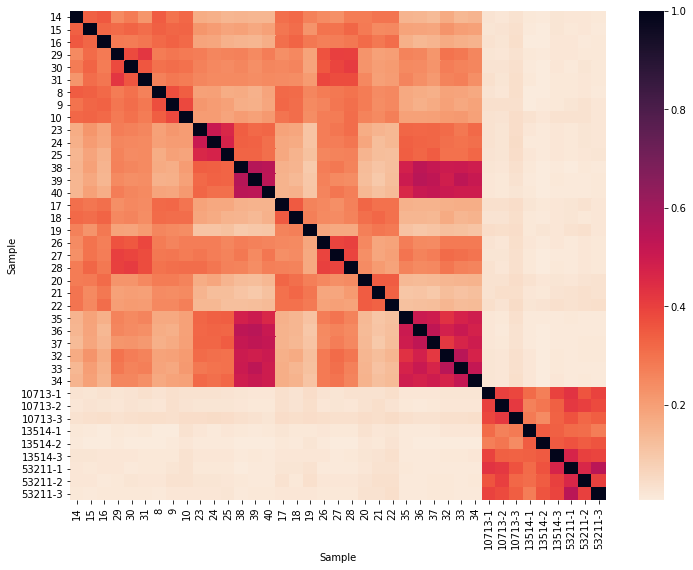

In [10]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


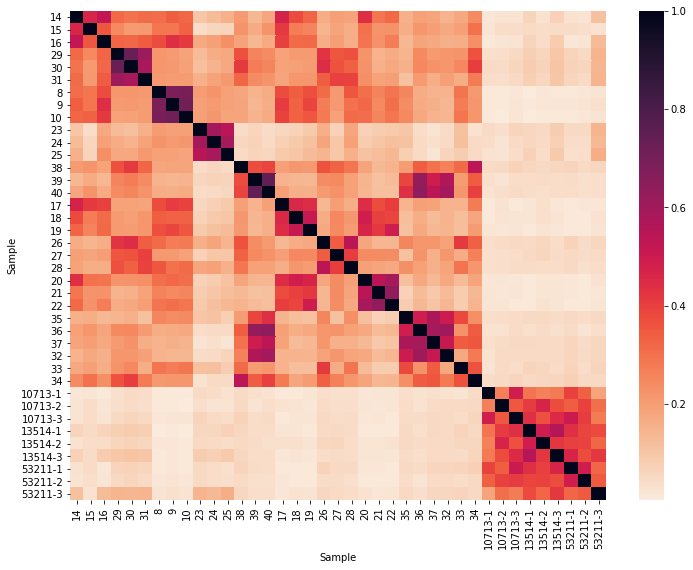

In [11]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [12]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=aligned_all_pos.cdl.unique_labels,
                     index=aligned_all_pos.cdl.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=aligned_all_neg.cdl.unique_labels,
                     index=aligned_all_neg.cdl.unique_labels)

Label similarity, positive mode


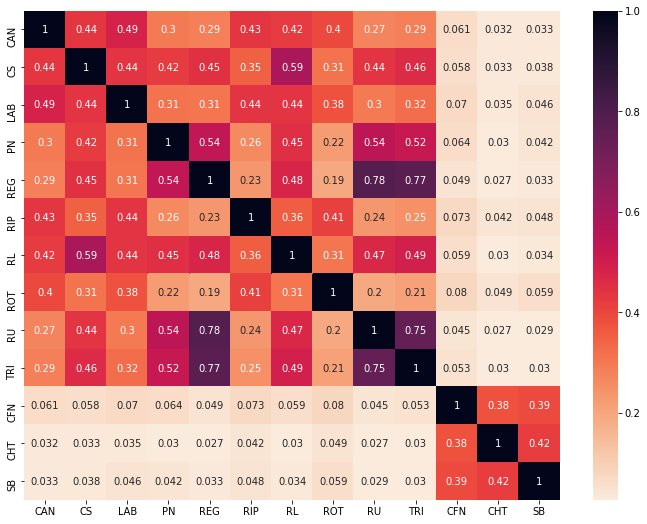

In [13]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


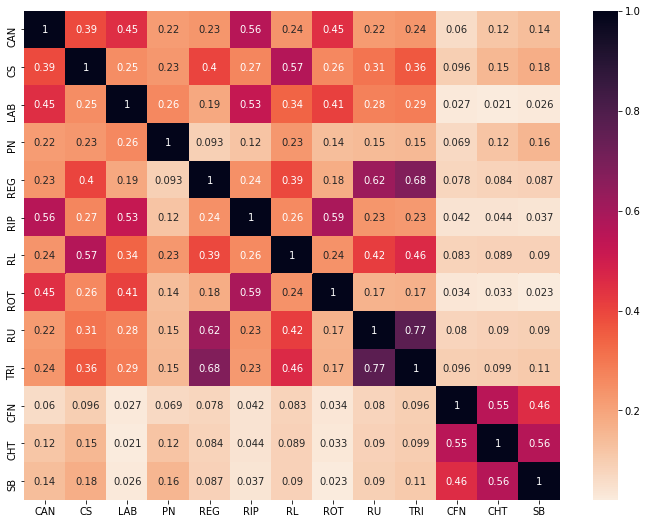

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Clustermap peak list function

In [15]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


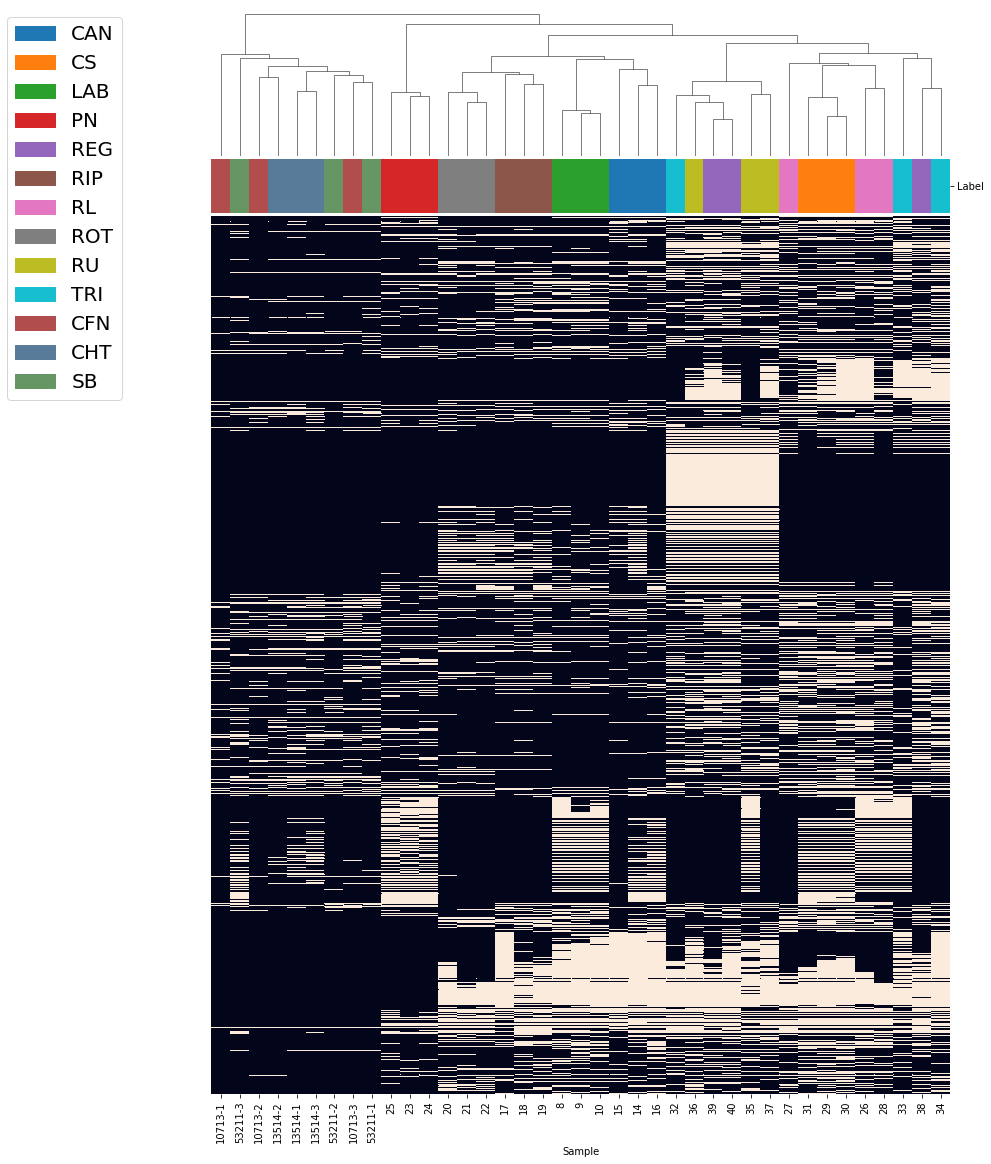

In [16]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


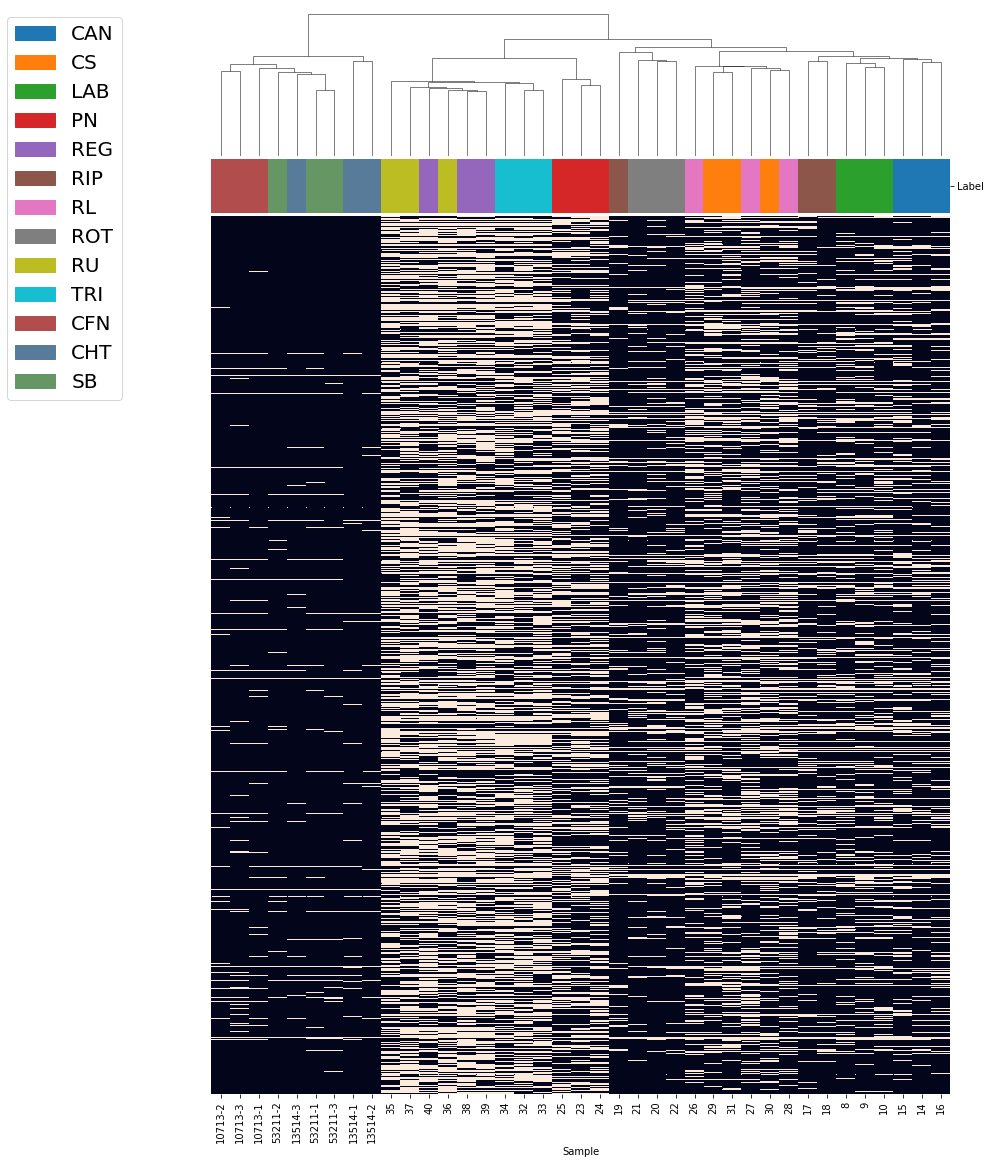

In [17]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Global metadata for consistency between tables and plots

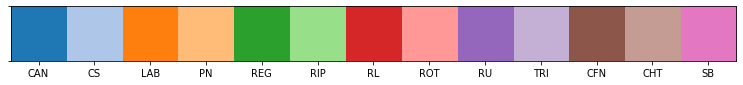

In [18]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab20', 13)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

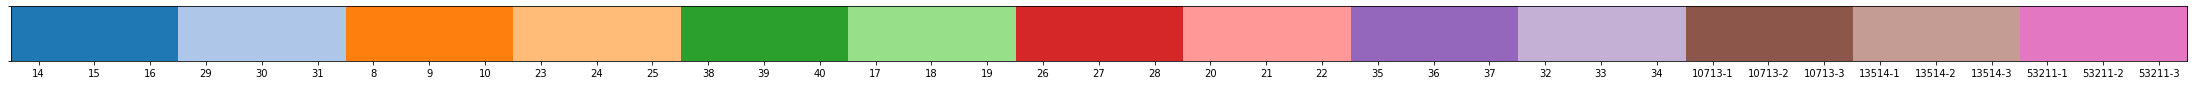

In [19]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3/4 types of processing are made:

(Imp (Ionly) - Only Missing Value Imputation).

P - Missing Value Imputation and Pareto Scaling.

NP - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

NGP - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [20]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [21]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(554.2620199999997, 0.0005199999997103077)
(556.2765712820516, 0.0005287179484412263)


In [22]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.2620199999997)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765712820516)

## Similarity analysis (Jaccard)

In [23]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

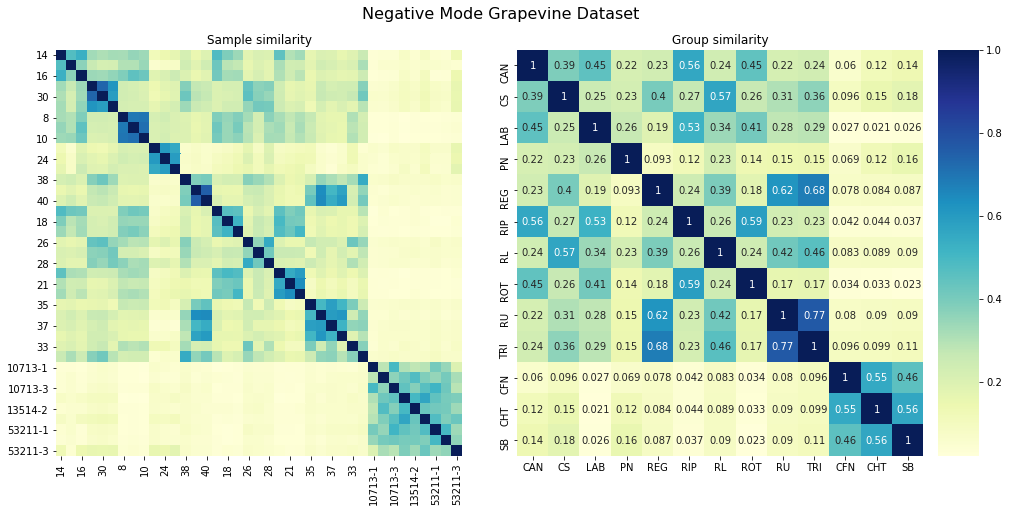

In [24]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset')

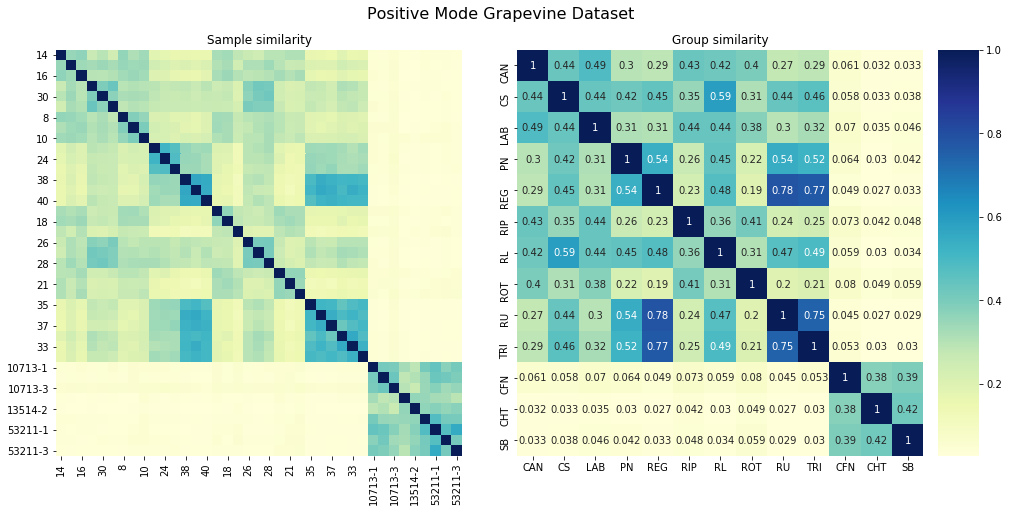

In [25]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [26]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
jsim.index.name = 'Sample'
jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset (cophenetic = 0.96548)


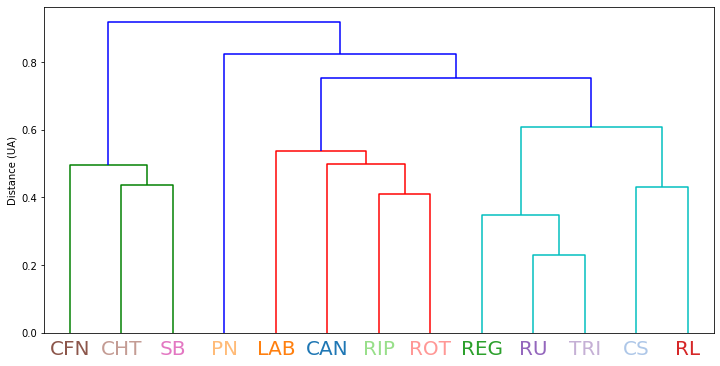

In [27]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset (cophenetic = 0.97828)


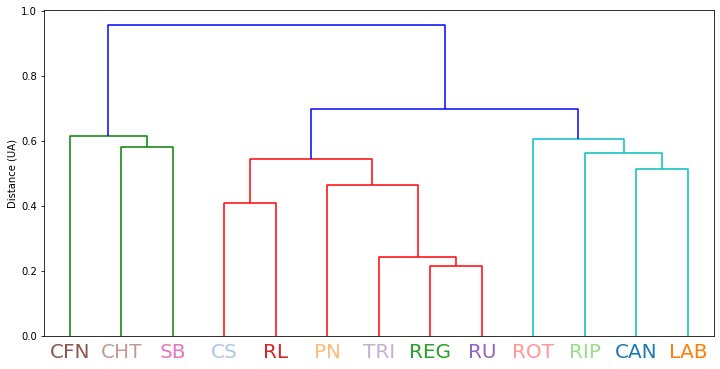

In [28]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.

In [29]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - 1-6 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

Each feature appears at least in 6 of 39 samples. 1_6 in figures.

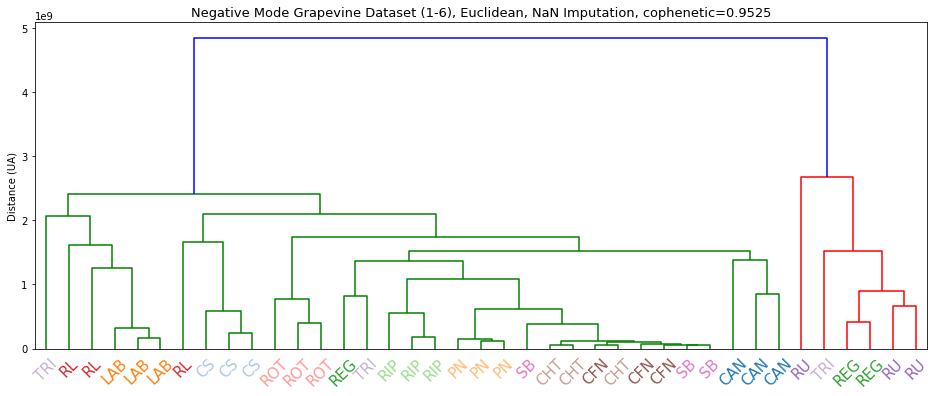

In [30]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

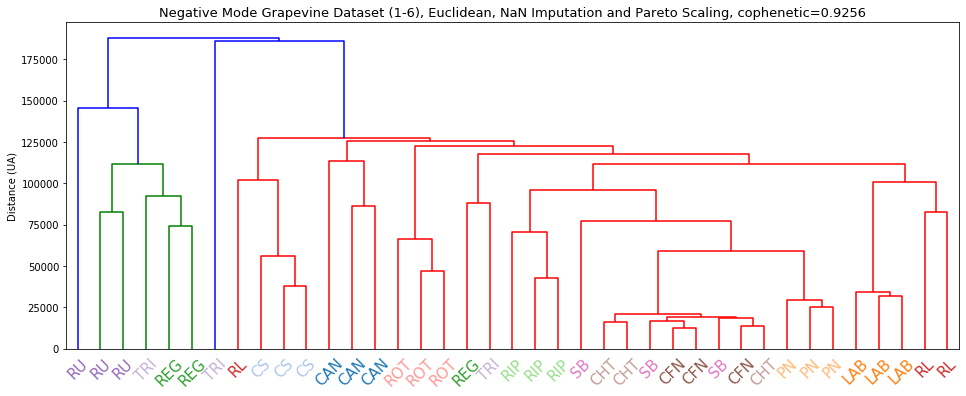

In [31]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

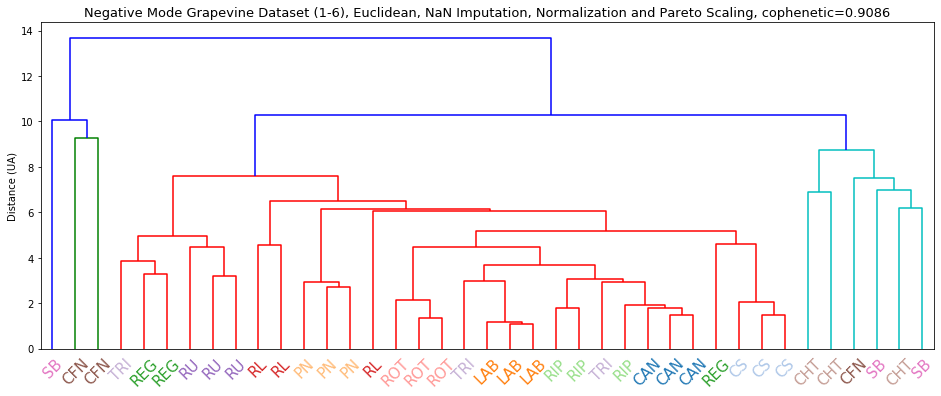

In [32]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

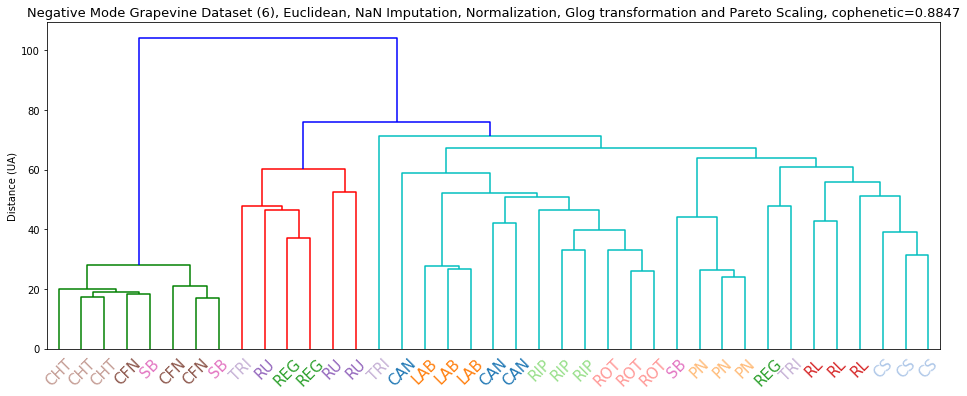

In [33]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (6), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

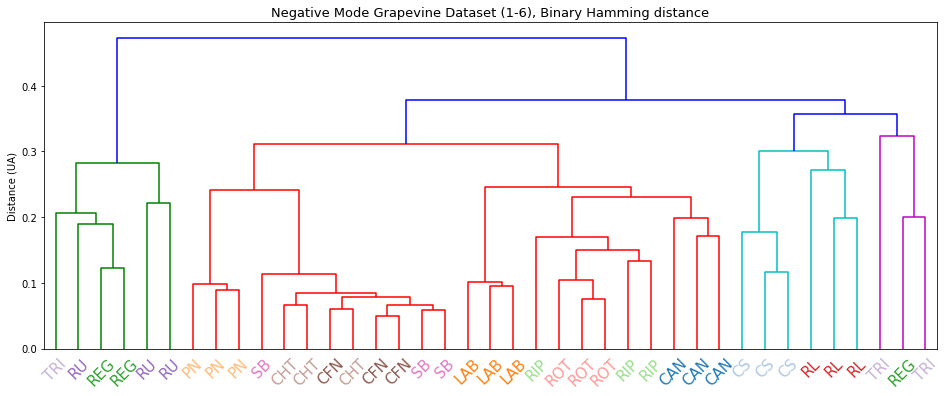

In [34]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (1-6), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Greys / Black and White matrixes depicting normal intensity / binary treated dataset (respectively)

Black and White - Binary treated Negative mode Grapevine dataset


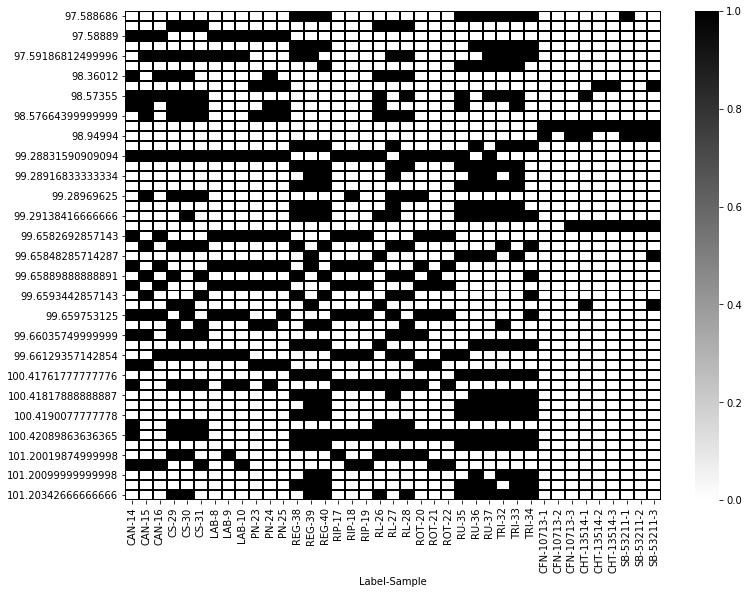

In [35]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(treat_neg['binary'].iloc[:50,:], annot=False, ax=ax, cmap = 'gray_r', linewidths = 1, linecolor = 'black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print('Black and White - Binary treated Negative mode Grapevine dataset')
plt.show()

Greys - Negative mode Grapevine dataset with Intensity data after NGP treatment


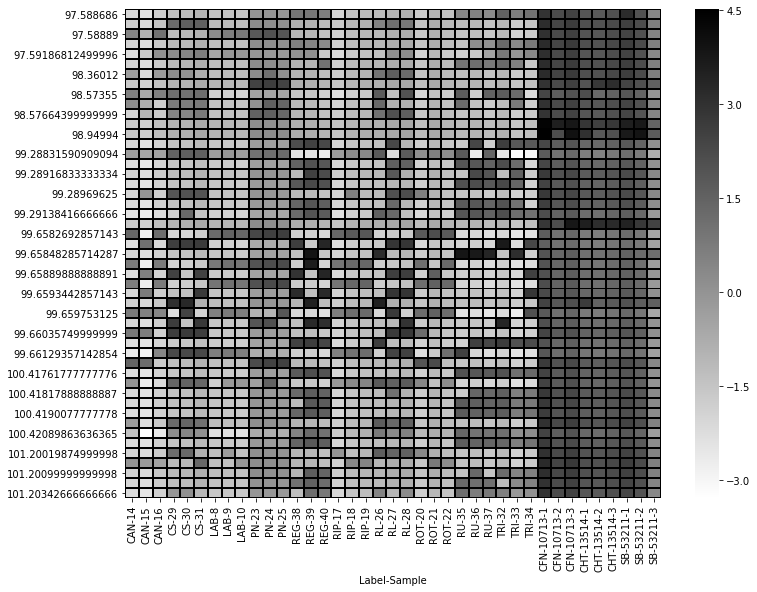

In [36]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(NGP_neg.iloc[:50,:], annot=False, ax=ax, cmap = 'gray_r', linewidths = 1, linecolor = 'black')#, yticklabels = Euc_NGP_neg.data.index[:100])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print('Greys - Negative mode Grapevine dataset with Intensity data after NGP treatment')
plt.show()

### Positive Mode - 1-6 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

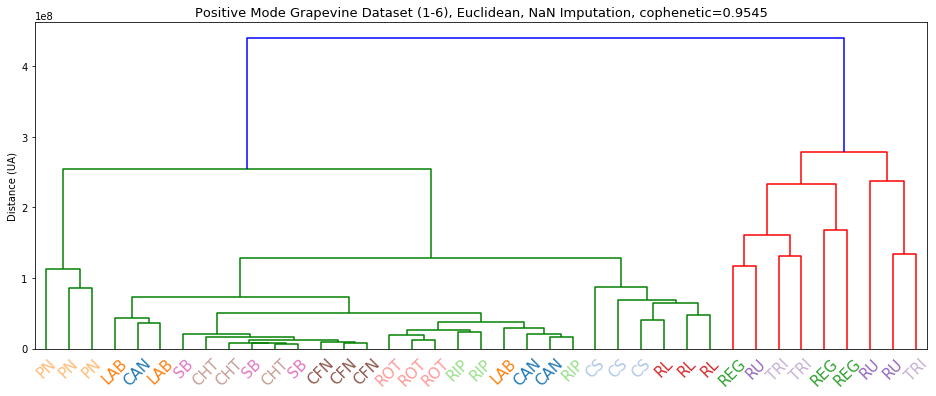

In [37]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

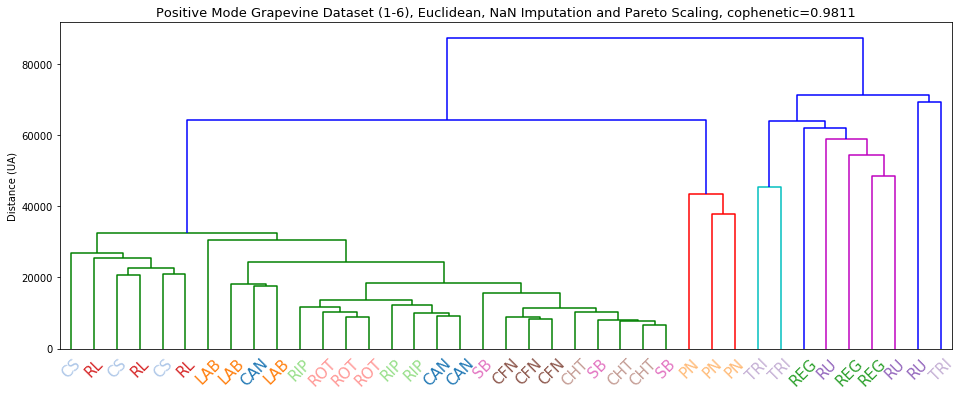

In [38]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

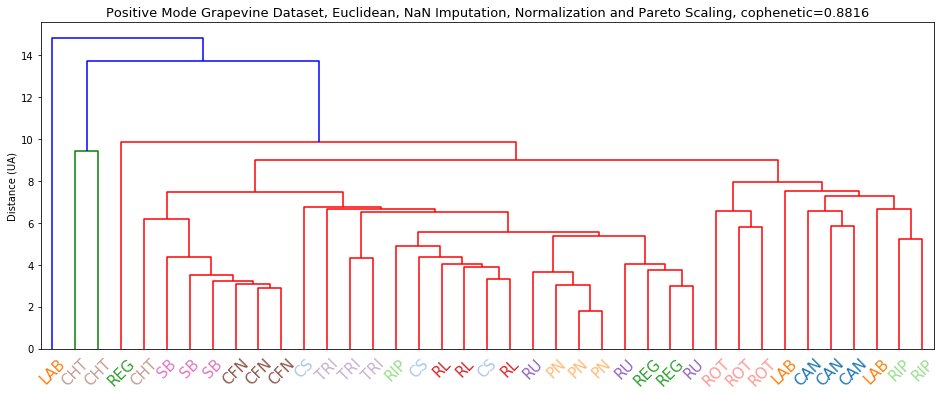

In [39]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset, Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

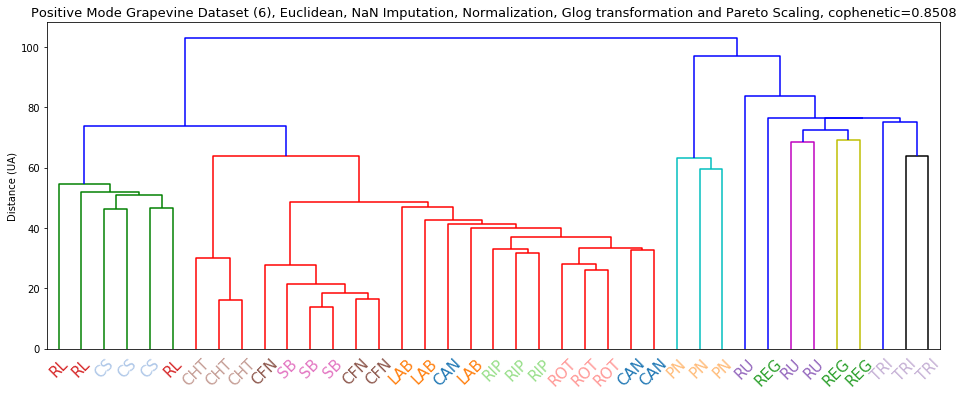

In [40]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (6), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

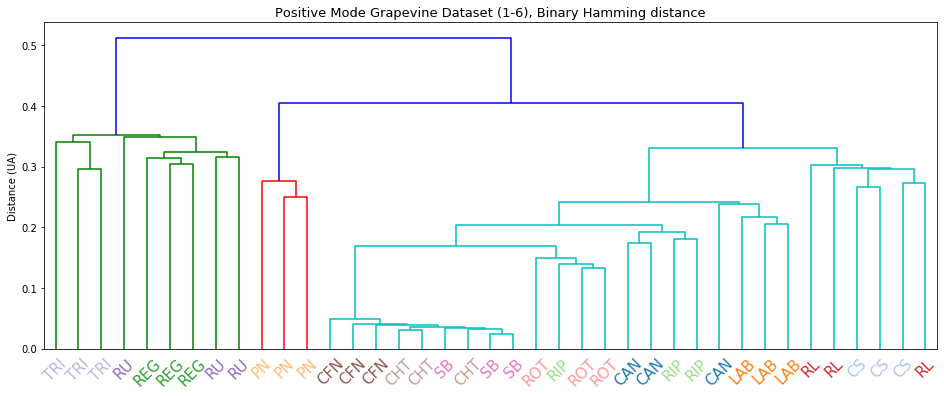

In [41]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (1-6), Binary Hamming distance'
plot_dendogram(Zdice, title)

## 2nd Peak Alignment - 1-2 / 1-13

Presented with 2 following the names. Example: treat_neg2.

#### Negative Mode - Peak alignment (only requires a feature to be present in at least 13 of the total 39 samples)

Same types of processing as before.

### 1-2 alignment - Currently in use

Each feature appears in at least 2 of the 39 samples. Appears as 1_2 in figures (may appear as 1_13).

In [42]:
aligned_all_pos2 = read_aligned_files('aligned_1ppm_min1-2_1ppm_positive.csv')
aligned_all_neg2 = read_aligned_files('aligned_1ppm_min1-2_1ppm_negative.csv')

### 1-13 alignment 

Each feature appears in at least 13 of the 39 samples. Appears as 1_13 in figures (may appear as 1_2).

In [43]:
#aligned_all_pos2 = read_aligned_files('aligned_1ppm_min13_1ppm_positive.csv')
#aligned_all_neg2 = read_aligned_files('aligned_1ppm_min13_1ppm_negative.csv')

#### Performing treatments

In [44]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.2771)
print(RefEst_Pos)

(554.2620199999997, 0.0005199999997103077)
(556.2765712820516, 0.0005287179484412263)


In [45]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.2620199999997)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.2765712820516)

### Negative Mode - 1-2 / 1-13 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

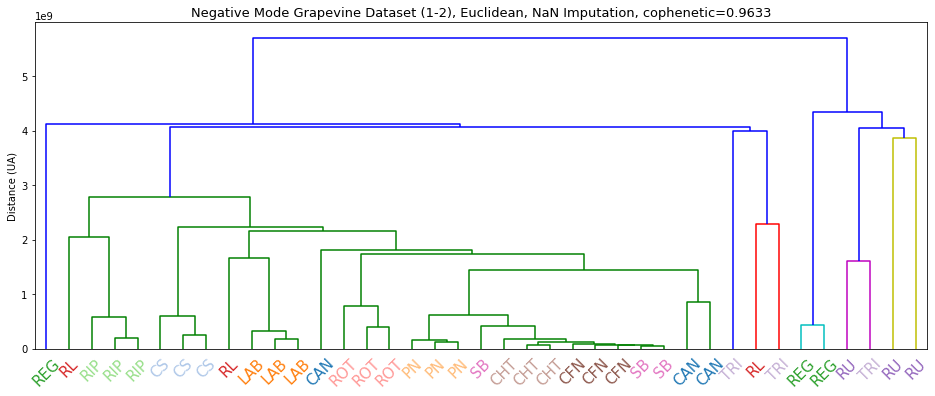

In [46]:
# Missing Value Imputation only
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg2, title)

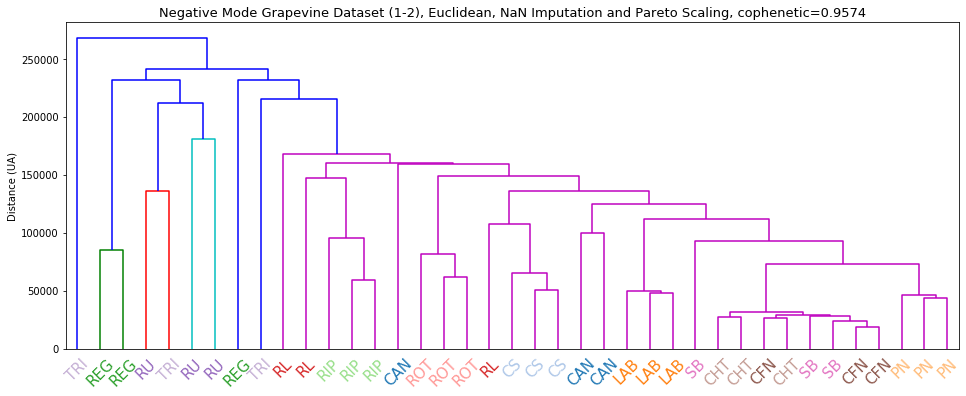

In [47]:
# Imputed and Pareto scaled
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

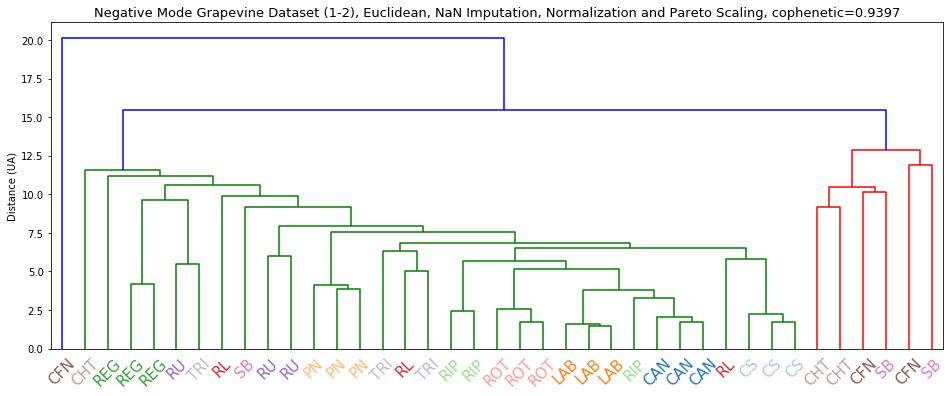

In [48]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

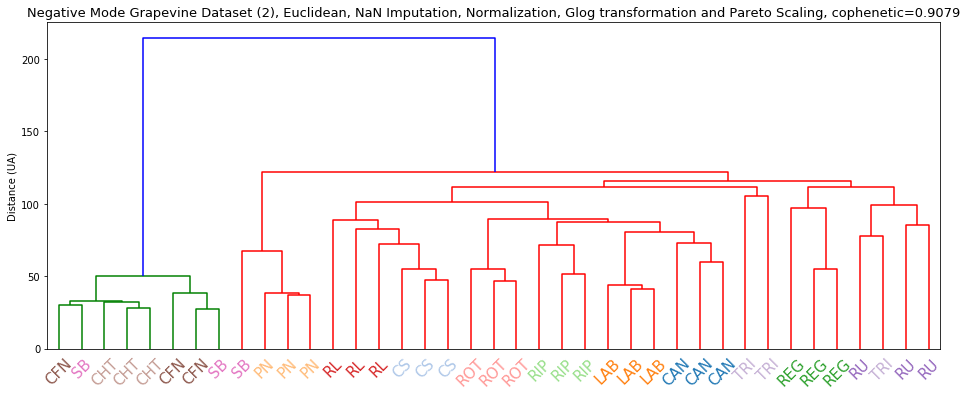

In [49]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

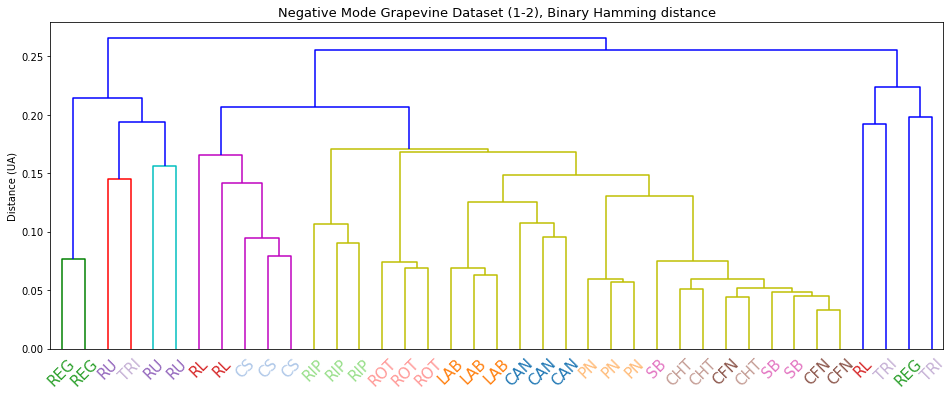

In [50]:
binary = treat_neg2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 1-2/1-13 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

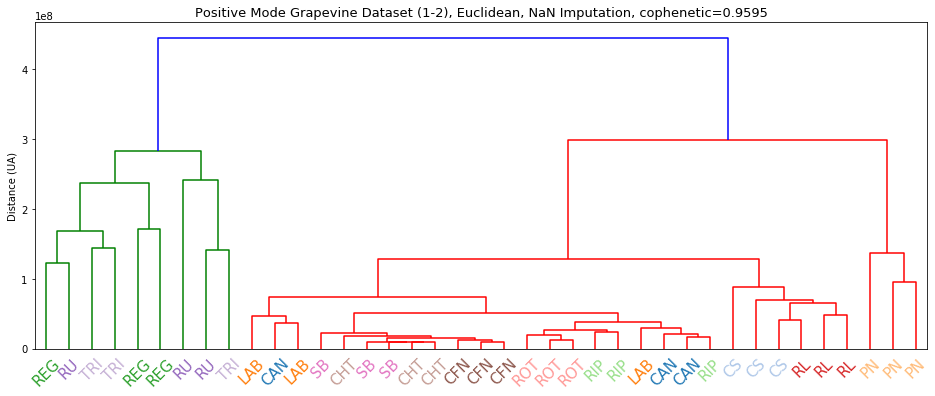

In [51]:
# Missing Value Imputation only
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos2, title)

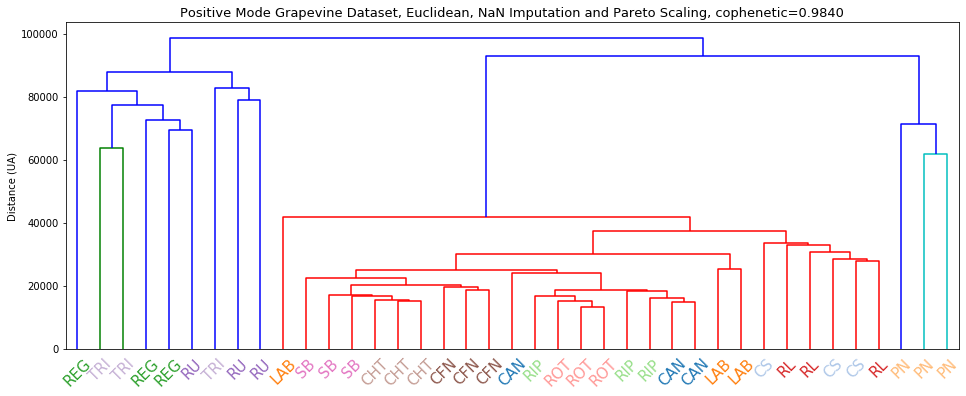

In [52]:
# Imputed and Pareto scaled
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

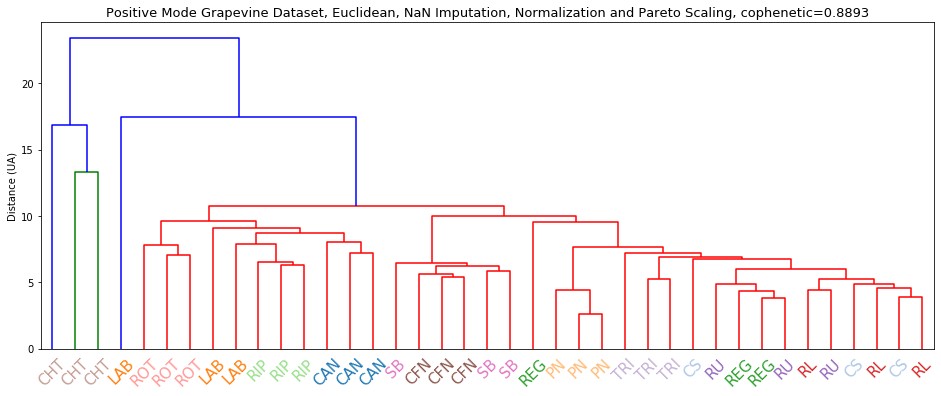

In [53]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset, Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

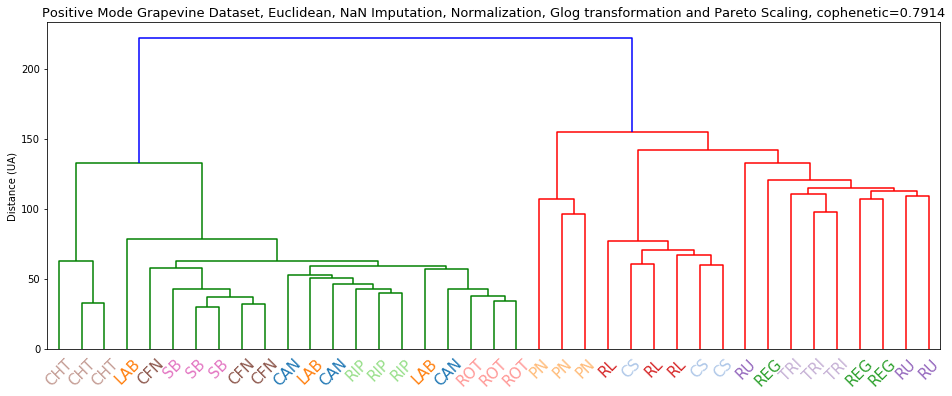

In [54]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset, Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

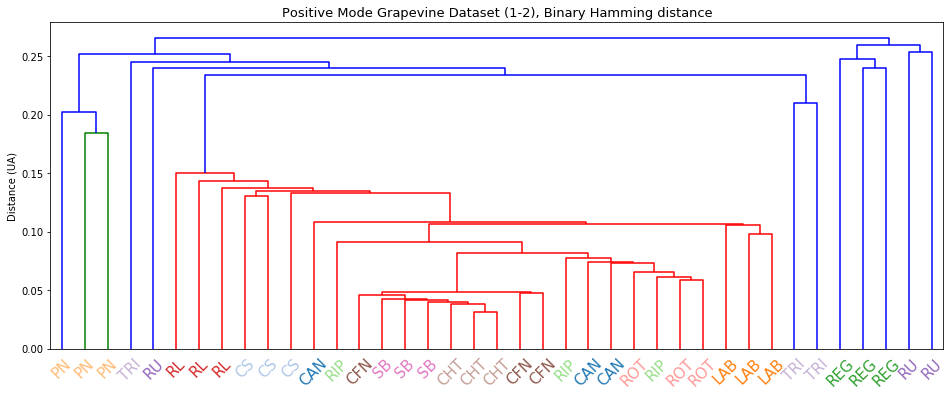

In [55]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Binary distances example for peak_alignment 2: 1-13

In [56]:
aligned_neg2 = df_to_bool(aligned_all_neg2)
aligned_pos2 = df_to_bool(aligned_all_pos2)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

#### Imp/Ionly not used in this comparison

In [57]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [58]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.002041799578803169 	 0.9166315654528232
Euc_P_neg-Euc_NGP_neg	 0.21791147234247937 	 7.434028253257683e-28


According to the explanation given in the R package dendextend

In [59]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 -0.01918838031233313 	 0.46043241635261234
Euc_P_neg-Euc_NGP_neg	 0.23469410325212842 	 5.4103448360308795e-20


#### Cophenetic Correlation Coefficient

In [60]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [61]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 -0.06404669610131176 	 0.08145927907592254
Euc_P_neg-Euc_NGP_neg	 0.3041690821215578 	 2.5106536355884203e-17


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

Change between number of binary metrics to use

In [62]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [63]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']
aligned_neg2 = treat_neg2['binary']
aligned_pos2 = treat_pos2['binary']

In [64]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [65]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [66]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [67]:
#Column names and row names for the dataframes
#3 binary metrics
#colnames = ['euc_P_neg1_6', 'euc_NP_neg1_6', 'euc_NGP_neg1_6', 'euc_P_pos1_6', 'euc_NP_pos1_6', 'euc_NGP_pos1_6',
#            'euc_P_neg1_2', 'euc_NP_neg1_2', 'euc_NGP_neg1_2', 'euc_P_pos1_2', 'euc_NP_pos1_2', 'euc_NGP_pos1_2', 
#            'hamming_neg1_6', 'jaccard_neg1_6', 'yule_neg1_6',  'hamming_pos1_6', 'jaccard_pos1_6', 'yule_pos1_6']

#9 binary metrics
colnames = ['euc_P_neg1_6', 'euc_NP_neg1_6', 'euc_NGP_neg1_6', 'euc_P_pos1_6', 'euc_NP_pos1_6', 'euc_NGP_pos1_6',
            'euc_P_neg1_2', 'euc_NP_neg1_2', 'euc_NGP_neg1_2', 'euc_P_pos1_2', 'euc_NP_pos1_2', 'euc_NGP_pos1_2',
            'dice_neg1_6', 'hamming_neg1_6', 'jaccard_neg1_6', 'rogerstanimoto_neg1_6', 'sokalmichener_neg1_6', 
            'sokalsneath_neg1_6','yule_neg1_6', 'kulsinski_neg1_6', 'russellrao_neg1_6','dice_pos1_6', 'hamming_pos1_6', 
            'jaccard_pos1_6', 'rogerstanimoto_pos1_6', 'sokalmichener_pos1_6', 'sokalsneath_pos1_6', 'yule_pos1_6', 
            'kulsinski_pos1_6', 'russellrao_pos1_6']

In [68]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [69]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


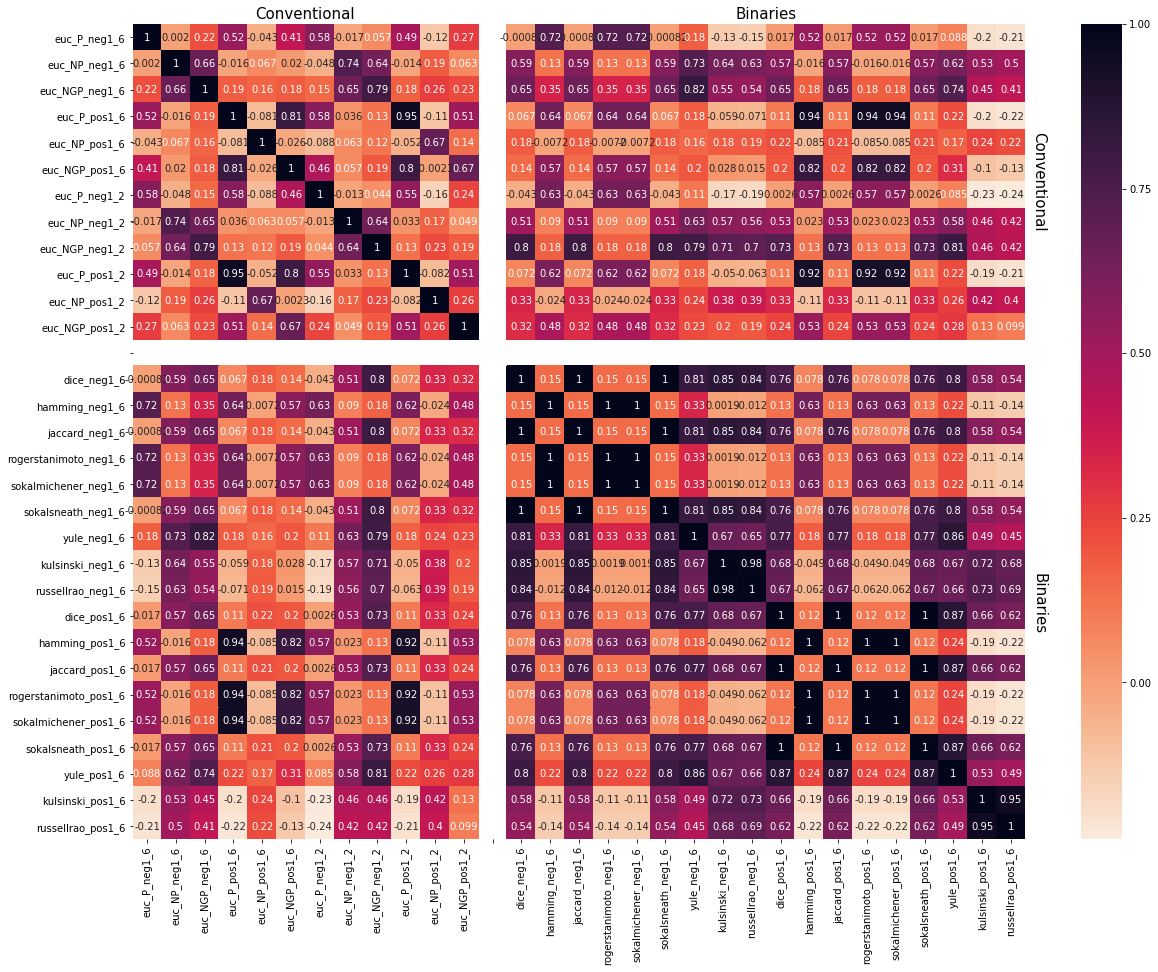

In [70]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [71]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg1-13', 
                                                                                                'pos1-13', 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_KI.iloc[13+r,j*3+2]#sum(df_KI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_KI.iloc[22+r,j*3+2]#sum(df_KI.iloc[22+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
#f, ax = plt.subplots(figsize=(5, 4))
#hm = sns.heatmap(Kendall, annot=True, ax=ax, cmap = sns.cm.rocket_r)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.show()
Kendall

neg2_1    pos2_1   neg1-13   pos1-13   neg+pos
dice            0.647392  0.200560  0.797897  0.241792  1.887642
hamming         0.345555  0.819753  0.175521  0.529468  1.870298
jaccard         0.647392  0.200474  0.797897  0.241704  1.887468
rogerstanimoto  0.345555  0.819753  0.175521  0.529468  1.870298
sokalmichener   0.345555  0.819753  0.175521  0.529468  1.870298
sokalsneath     0.647392  0.200474  0.797897  0.241704  1.887468
yule            0.822112  0.314816  0.789247  0.278031  2.204207
kulsinski       0.548932 -0.104904  0.707760  0.129518  1.281305
russellrao      0.535570 -0.129810  0.697382  0.098833  1.201975

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


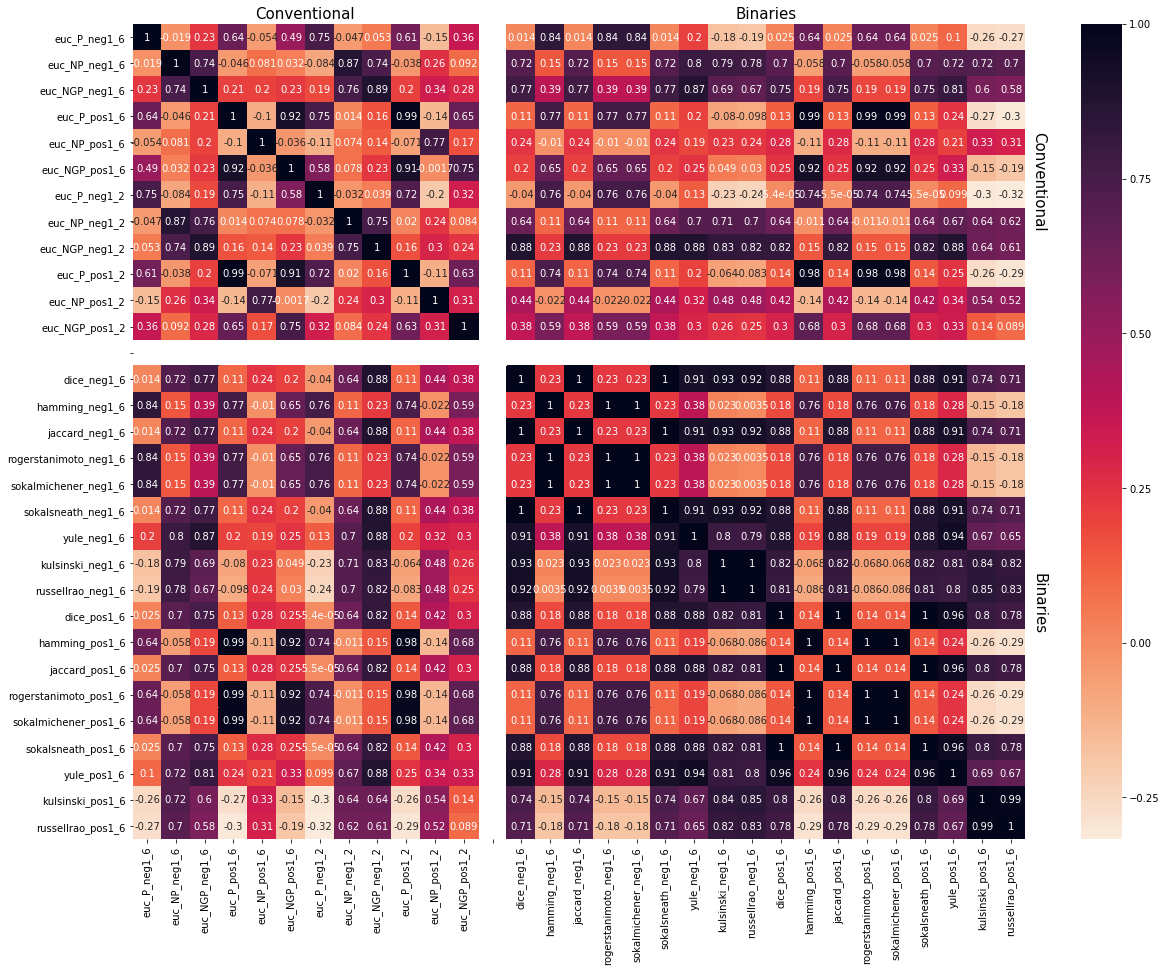

In [72]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


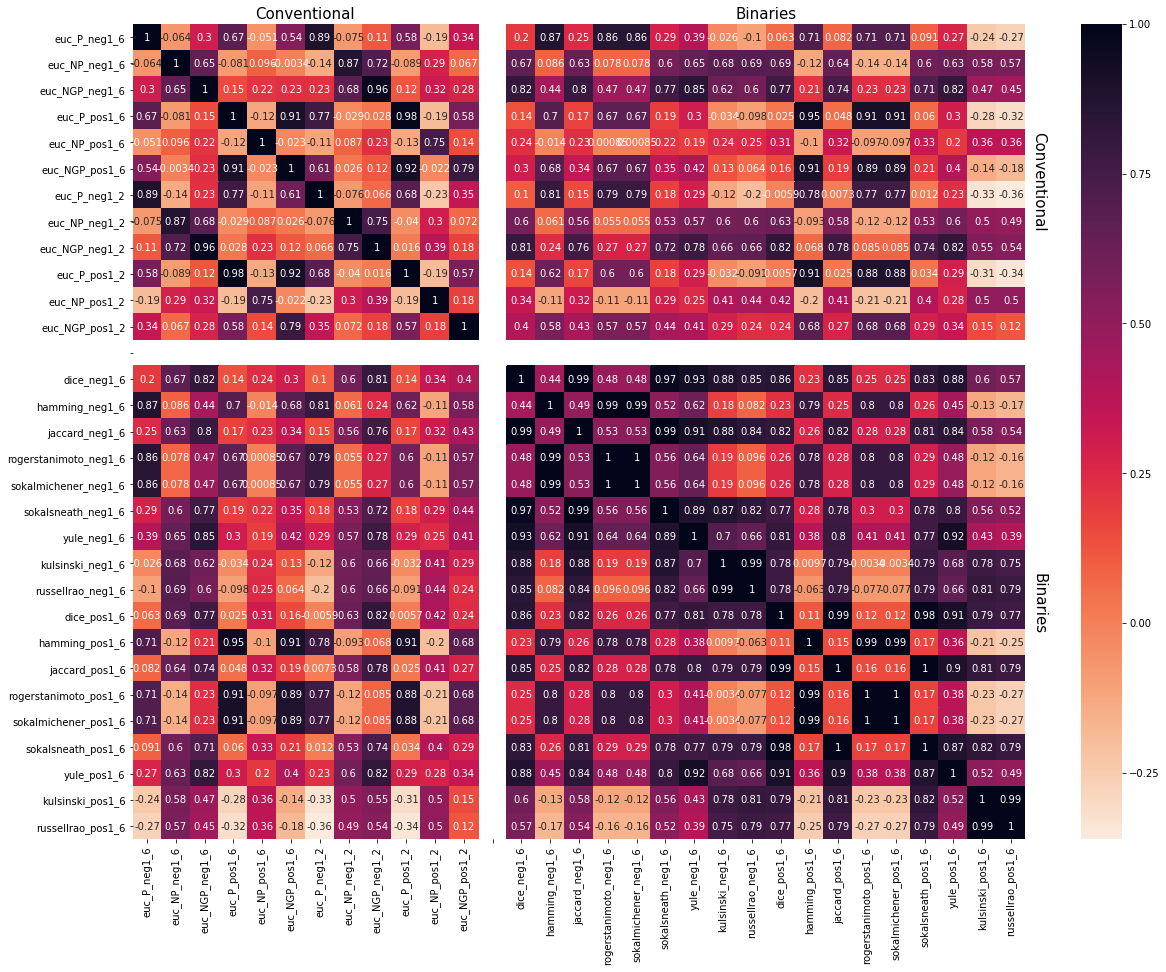

In [73]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [74]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg1-2', 
                                                                                                'pos1-2','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_CI.iloc[13+r,j*3+2]#sum(df_CI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_CI.iloc[22+r,j*3+2]#sum(df_CI.iloc[22+r,j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
Cophenetic

neg2_1    pos2_1    neg1-2    pos1-2   neg+pos
dice            0.817411  0.157576  0.805200  0.242398  2.022585
hamming         0.439918  0.906981  0.239997  0.681524  2.268420
jaccard         0.796671  0.188378  0.761145  0.272424  2.018618
rogerstanimoto  0.472602  0.888497  0.274429  0.682870  2.318398
sokalmichener   0.472602  0.888497  0.274429  0.682870  2.318398
sokalsneath     0.768042  0.205104  0.716005  0.290172  1.979322
yule            0.845007  0.400292  0.780841  0.339680  2.365819
kulsinski       0.621395 -0.138560  0.658694  0.149919  1.291449
russellrao      0.595636 -0.182886  0.660025  0.121196  1.193971

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [75]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


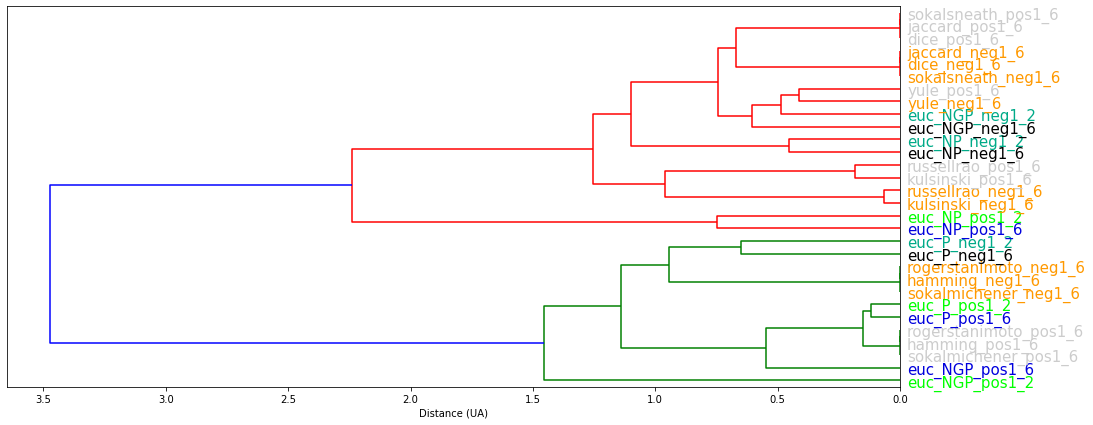

In [76]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


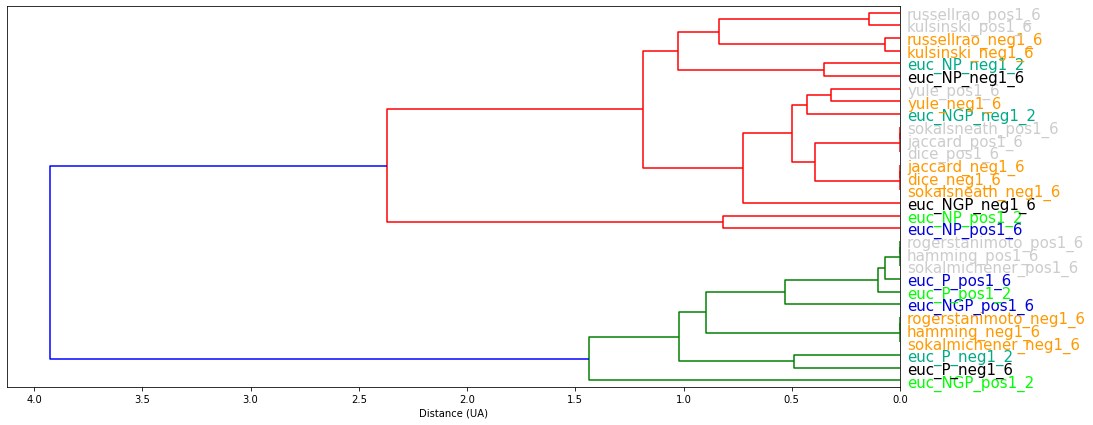

In [77]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


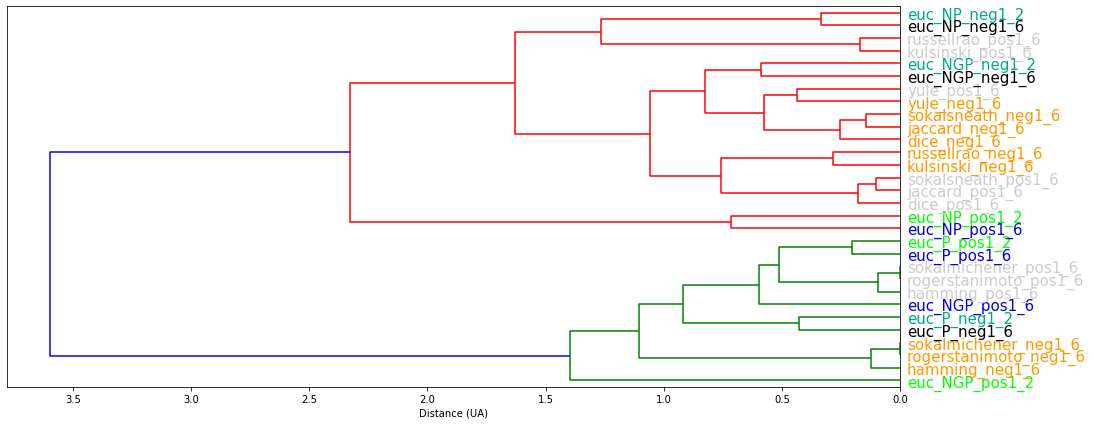

In [78]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('Euc1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [79]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [80]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    data = aligned_all_neg
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

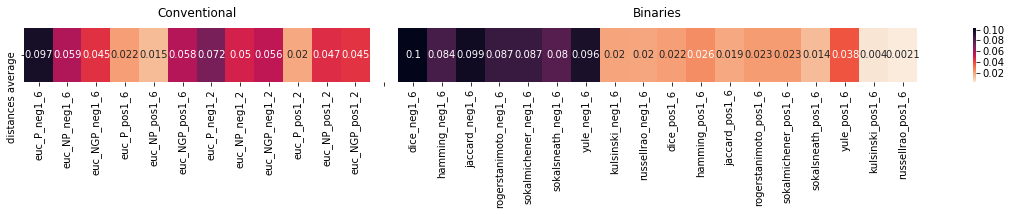

In [81]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

In [82]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

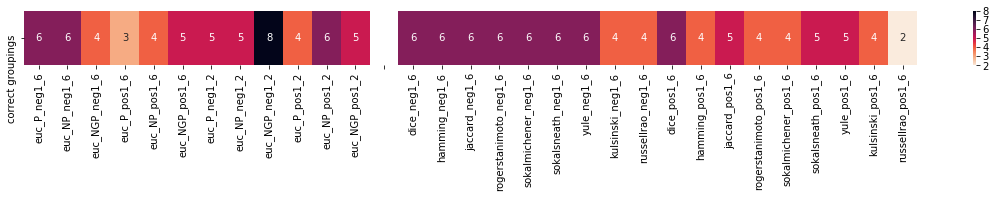

In [83]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### 1-2 (1-13) binaries discrimination distance

In [84]:
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg2.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg2.T, metric = binary[i]))) #Cophenetic

#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos2.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos2.T, metric = binary[i]))) #Cophenetic

In [85]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [86]:
colnames_ex = ['euc_P_neg1_6', 'euc_NP_neg1_6', 'euc_NGP_neg1_6', 'euc_P_pos1_6', 'euc_NP_pos1_6', 'euc_NGP_pos1_6',
            'euc_P_neg1_2', 'euc_NP_neg1_2', 'euc_NGP_neg1_2', 'euc_P_pos1_2', 'euc_NP_pos1_2', 'euc_NGP_pos1_2',
            'dice_neg1_2', 'hamming_neg1_13', 'jaccard_neg1_13', 'rogerstanimoto_neg1_13', 'sokalmichener_neg1_2', 
            'sokalsneath_neg1_2','yule_neg1_2', 'kulsinski_neg1_2', 'russellrao_neg1_2', 'dice_pos1_2', 'hamming_pos1_2', 
            'jaccard_pos1_2', 'rogerstanimoto_pos1_2', 'sokalmichener_pos1_2', 'sokalsneath_pos1_2', 'yule_pos1_2', 
            'kulsinski_pos1_2', 'russellrao_pos1_2']

In [87]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    discrim = ma.dist_discrim(aligned_all_neg, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(aligned_all_neg, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames_ex)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames_ex)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames_ex)

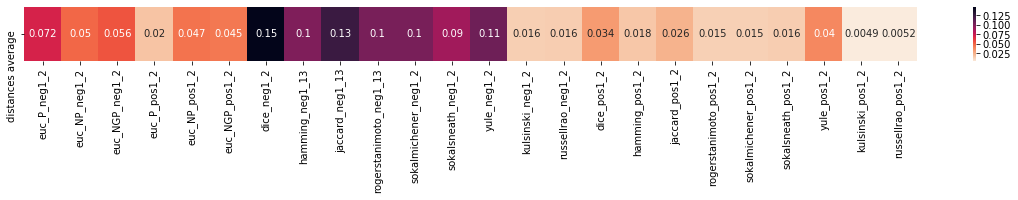

In [88]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

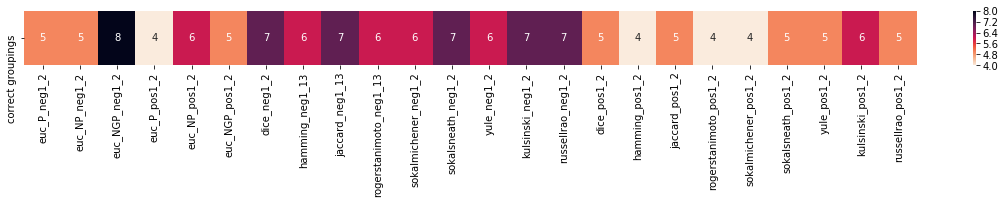

In [89]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [90]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### Extra binary measures of peak alignment 2: 1-13

In [91]:
sim_pos2 = mz_similarity(aligned_all_pos2, has_labels = True)
sim_neg2 = mz_similarity(aligned_all_neg2, has_labels = True)

Sample HC, NEGATIVE mode, Peak Alignment: 1-2


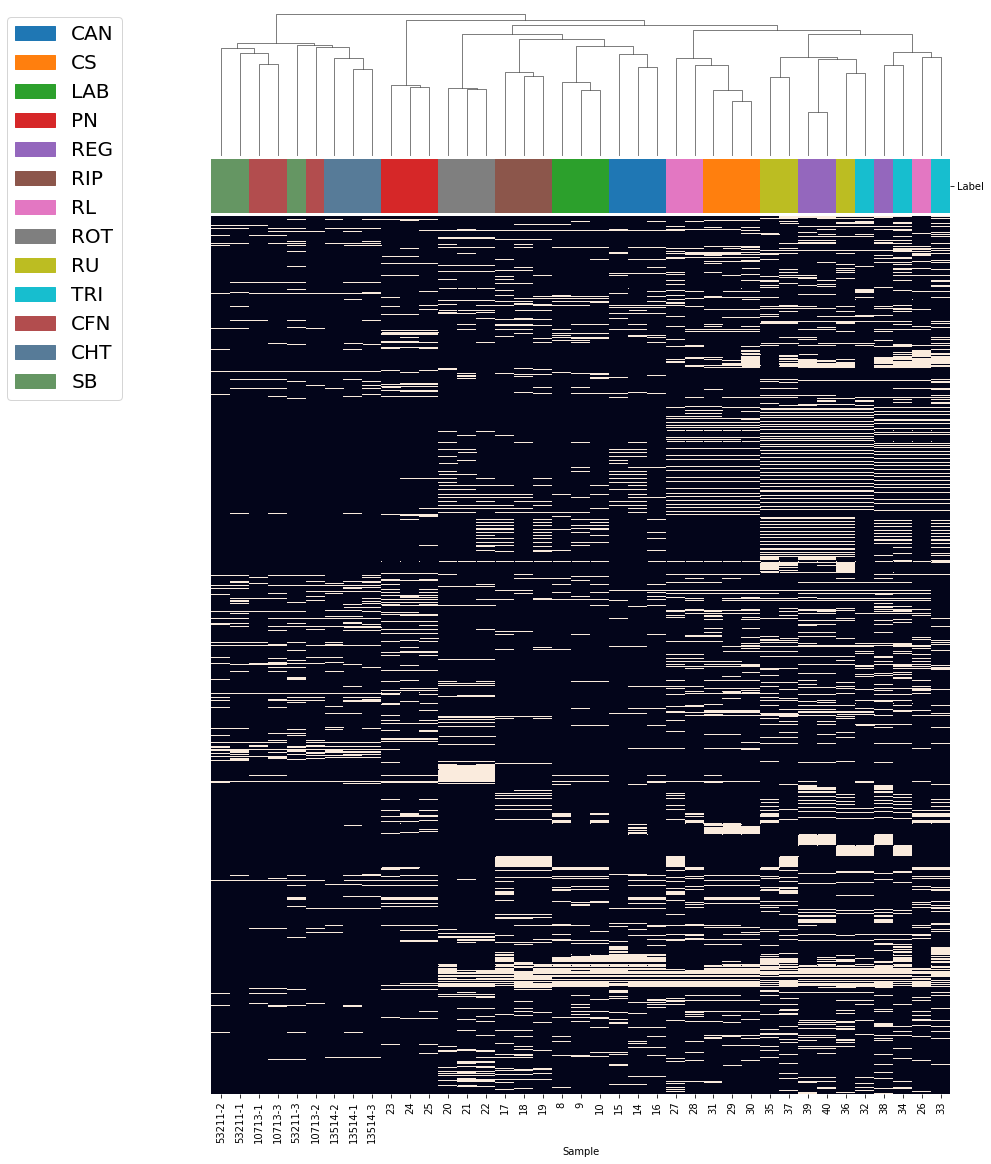

In [92]:
print('Sample HC, NEGATIVE mode, Peak Alignment: 1-2')
g = clustermap_peak_list(aligned_all_neg2)

Sample HC, POSITIVE mode, Peak Alignment: 1-2


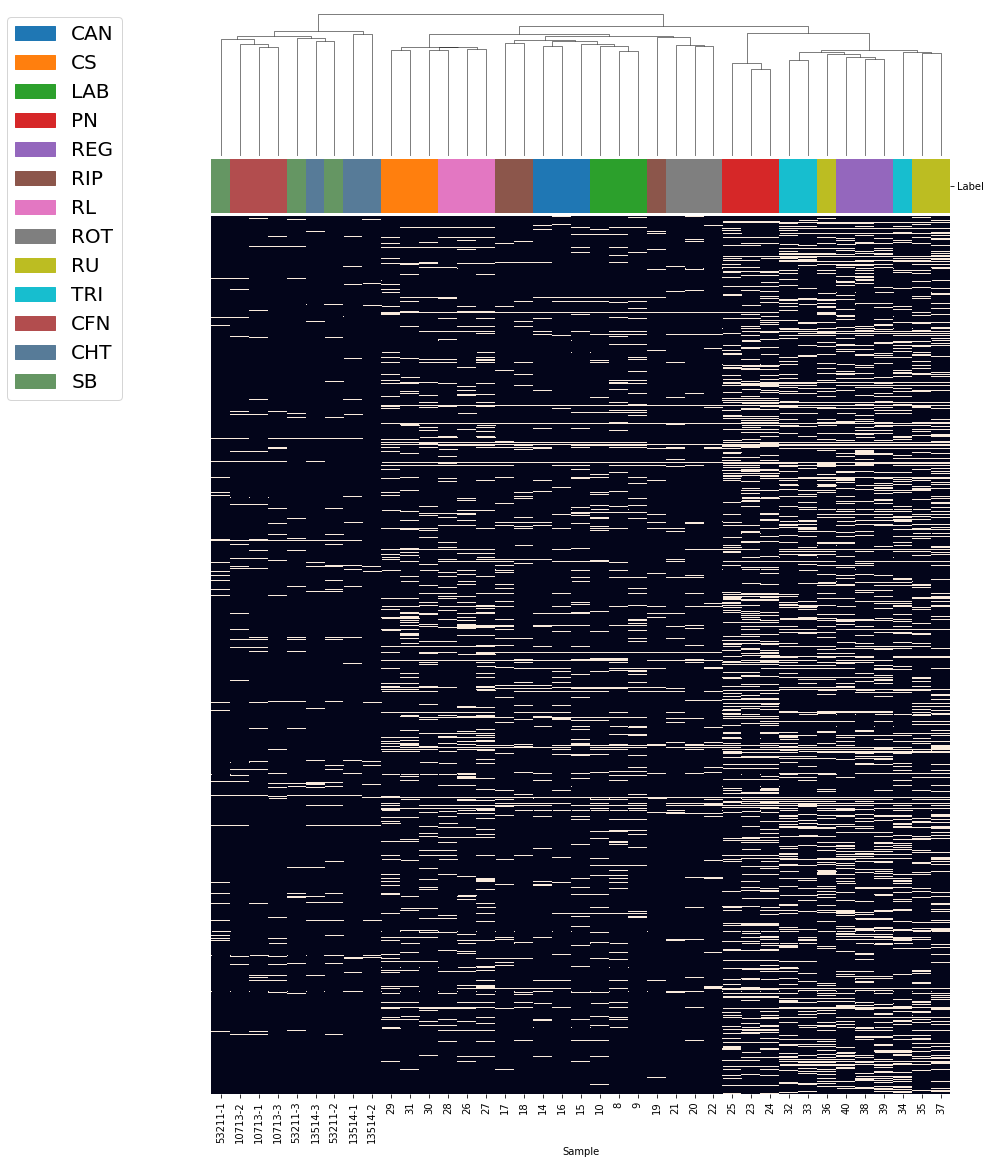

In [93]:
print('Sample HC, POSITIVE mode, Peak Alignment: 1-2')
g = clustermap_peak_list(aligned_all_pos2)

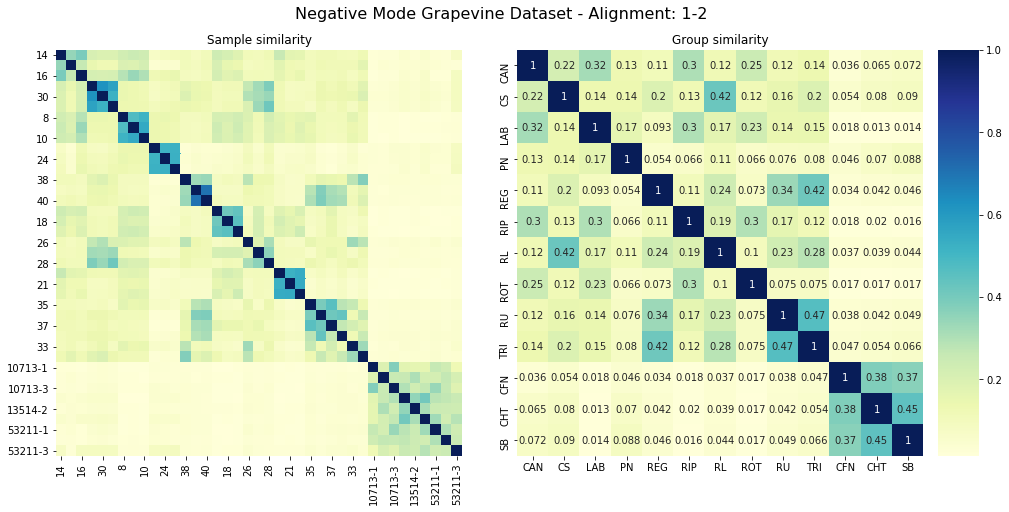

In [94]:
plot_jaccard_sims(aligned_all_neg2, 'Negative Mode Grapevine Dataset - Alignment: 1-2')

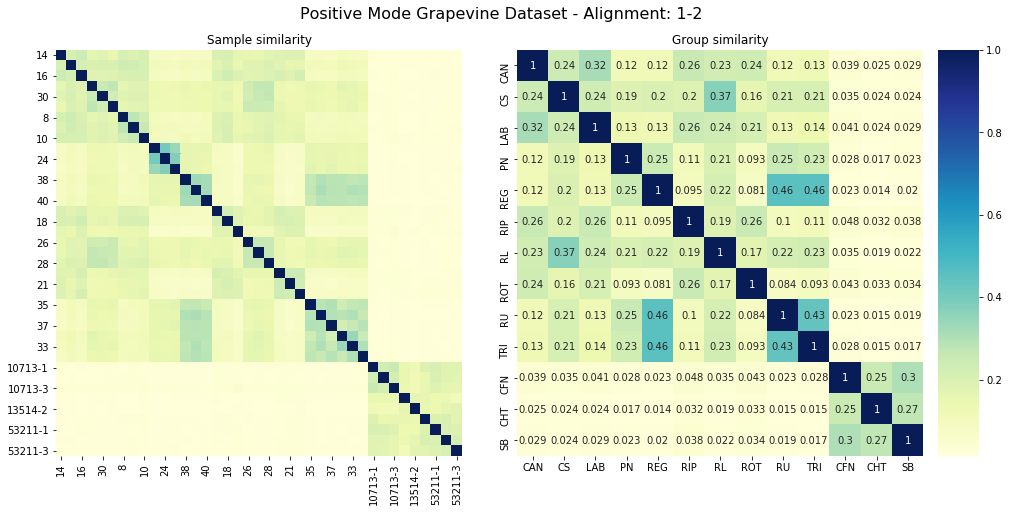

In [95]:
plot_jaccard_sims(aligned_all_pos2, 'Positive Mode Grapevine Dataset - Alignment: 1-2')

### K-means clustering

In [96]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [97]:
Kmean = skclust.KMeans(n_clusters=13)

In [98]:
a = Kmean.fit(NGP_neg.T)

In [99]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{10: ['CAN', 'CAN'],
 7: ['CAN', 'RIP'],
 5: ['CS', 'CS', 'CS'],
 2: ['LAB', 'LAB', 'LAB'],
 4: ['PN', 'PN', 'PN', 'SB'],
 9: ['REG', 'TRI'],
 8: ['REG', 'REG'],
 3: ['RIP', 'RIP', 'ROT', 'ROT', 'ROT'],
 6: ['RL', 'RL', 'RL'],
 12: ['RU', 'RU'],
 0: ['RU', 'TRI'],
 11: ['TRI'],
 1: ['CFN', 'CFN', 'CFN', 'CHT', 'CHT', 'CHT', 'SB', 'SB']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [100]:
colnames2 = ['euc_P_neg1_6', 'euc_NP_neg1_6', 'euc_NGP_neg1_6', 'euc_P_pos1_6', 'euc_NP_pos1_6', 'euc_NGP_pos1_6',
             'euc_P_neg1_2', 'euc_NP_neg1_2', 'euc_NGP_neg1_2', 'euc_P_pos1_2', 'euc_NP_pos1_2', 'euc_NGP_pos1_2',
             'aligned_neg1_6', 'aligned_pos1_6','aligned_neg1_2', 'aligned_pos1_2']

In [101]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [102]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

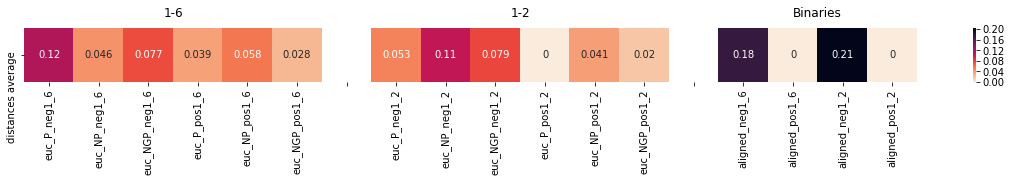

In [103]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

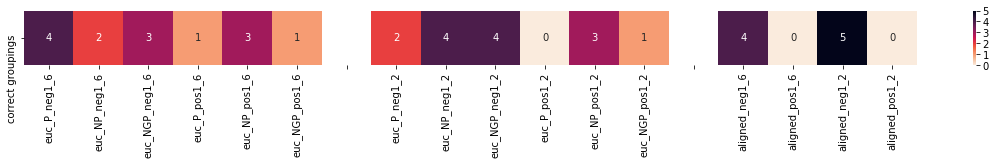

In [104]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [105]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [106]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,600,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [107]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

In [108]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg ... Done!
Fitting P_neg ... Done!
Fitting NP_neg ... Done!
Fitting NGP_neg ... Done!
Fitting bin_neg ... Done!
Fitting I_pos ... Done!
Fitting P_pos ... Done!
Fitting NP_pos ... Done!
Fitting NGP_pos ... Done!
Fitting bin_pos ... Done!
Fitting I_neg2 ... Done!
Fitting P_neg2 ... Done!
Fitting NP_neg2 ... Done!
Fitting NGP_neg2 ... Done!
Fitting bin_neg2 ... Done!
Fitting I_pos2 ... Done!
Fitting P_pos2 ... Done!
Fitting NP_pos2 ... Done!
Fitting NGP_pos2 ... Done!
Fitting bin_pos2 ... Done!


Performance based on number of trees - Alignment: 1-6, Negative Mode


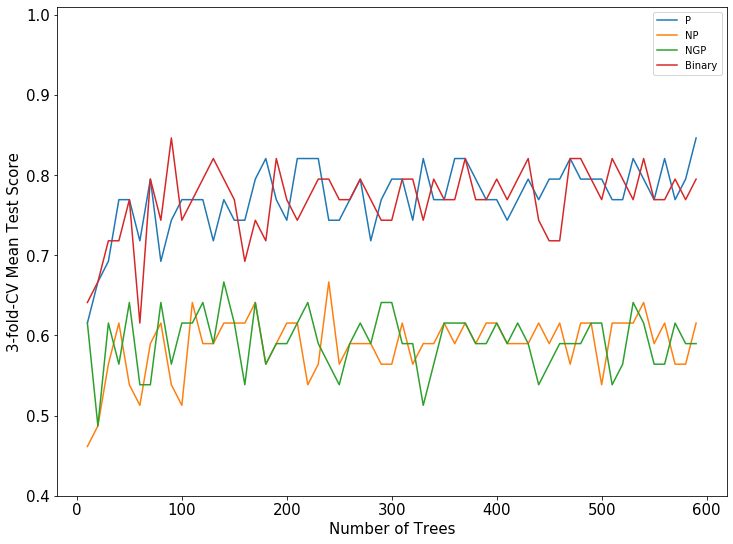

In [109]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(1,5):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Negative Mode')

Performance based on number of trees - Alignment: 1-6, Positive Mode


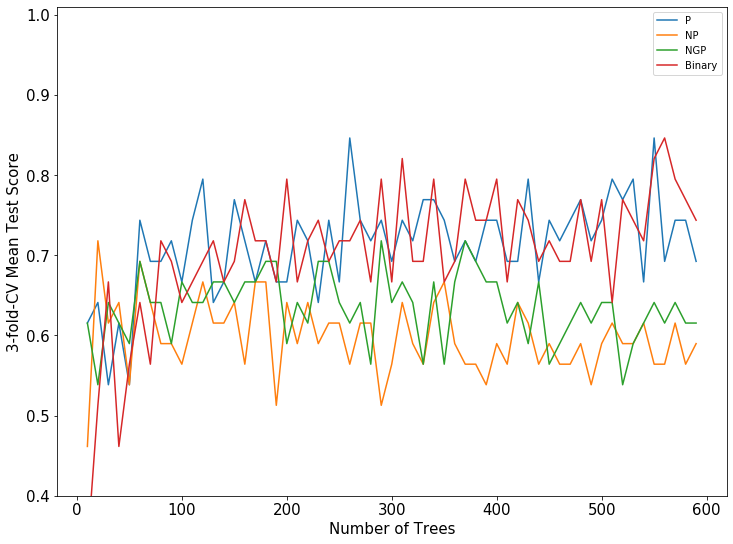

In [110]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(6,10):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Positive Mode')

Performance based on number of trees - Alignment: 1-2, Negative Mode


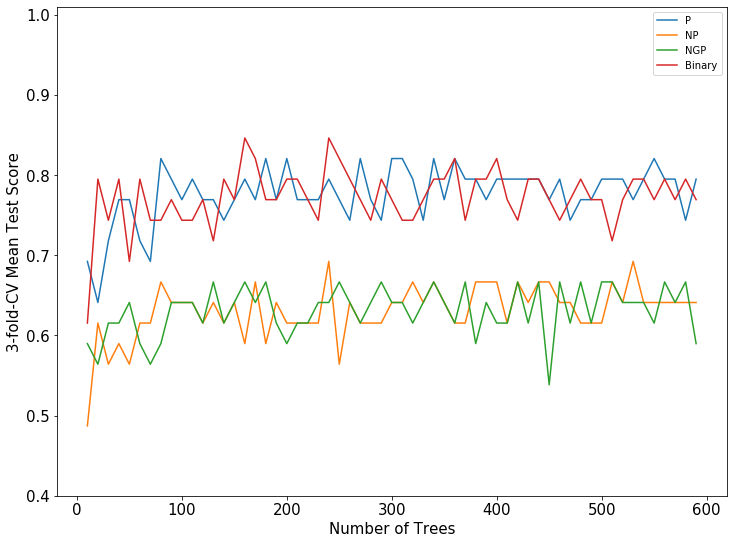

In [111]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(11,15):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Negative Mode')

Performance based on number of trees - Alignment: 1-2, Positive Mode


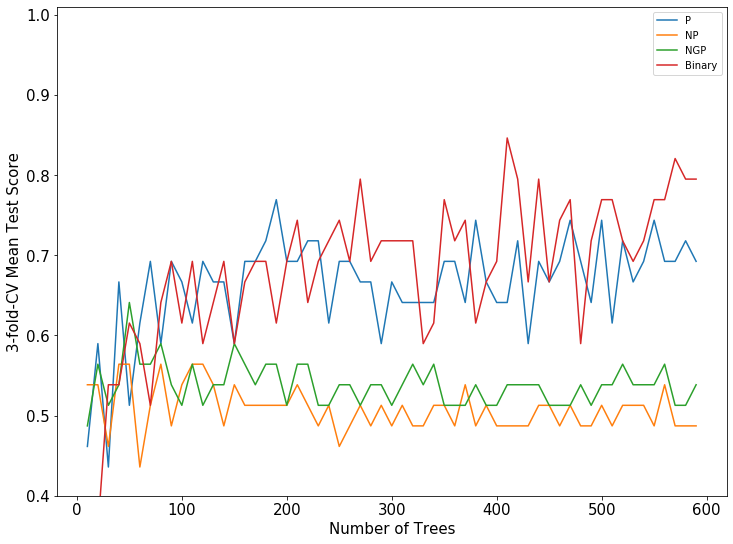

In [112]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(16,20):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Positive Mode')

### Performance of N, NP and NGP data treatments (alignments 1-6 and 1-2 (-1-13))

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [113]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [114]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done
Fitting random forest for I_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for bin_pos ...done
Fitting random forest for I_neg2 ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for I_pos2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for bin_pos2 ...done


Accuracy based on the dataset


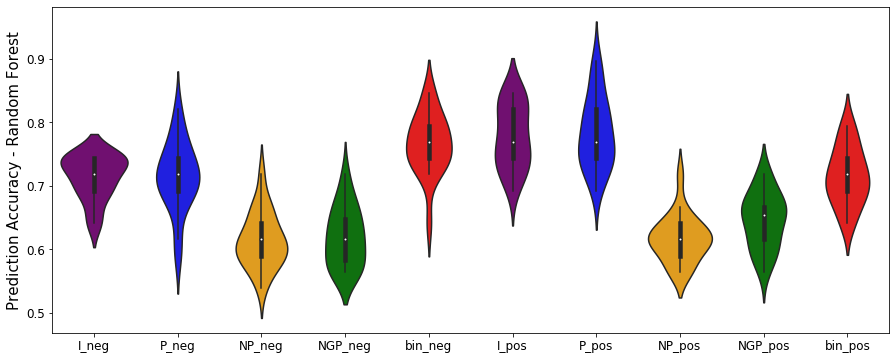

In [115]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,:10], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


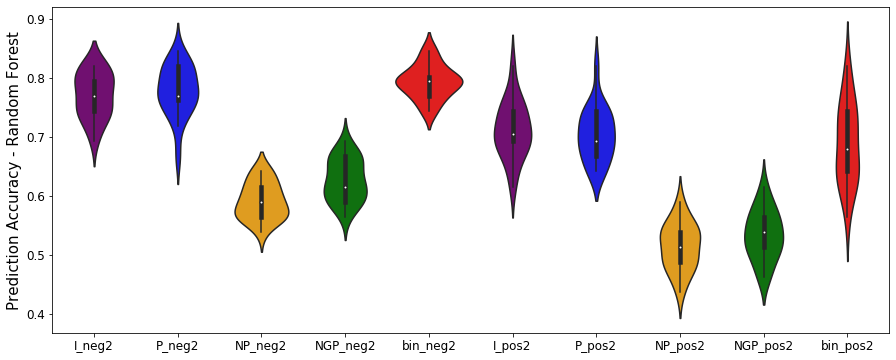

In [116]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,10:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [117]:
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.mean(Teste[i])

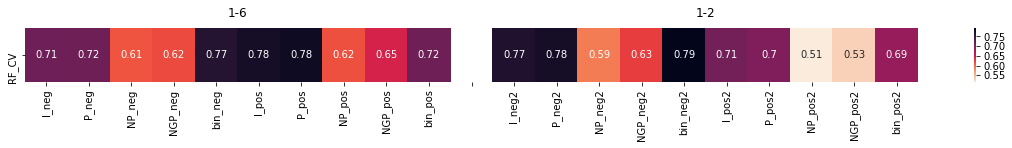

In [118]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,10:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

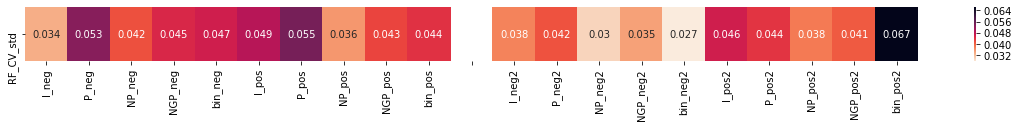

In [119]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_std_H = pd.concat([Teste_std_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,10:]], 
                        axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [120]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

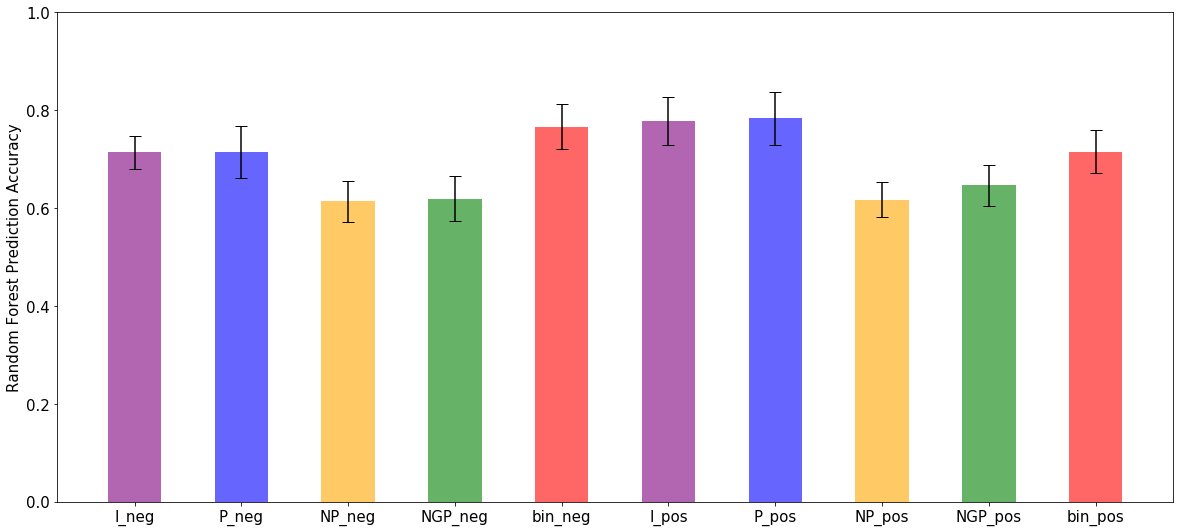

In [121]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:10], x = Teste_H.columns[0:10], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:10], y = Teste_H.T['Accuracy'][0:10], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

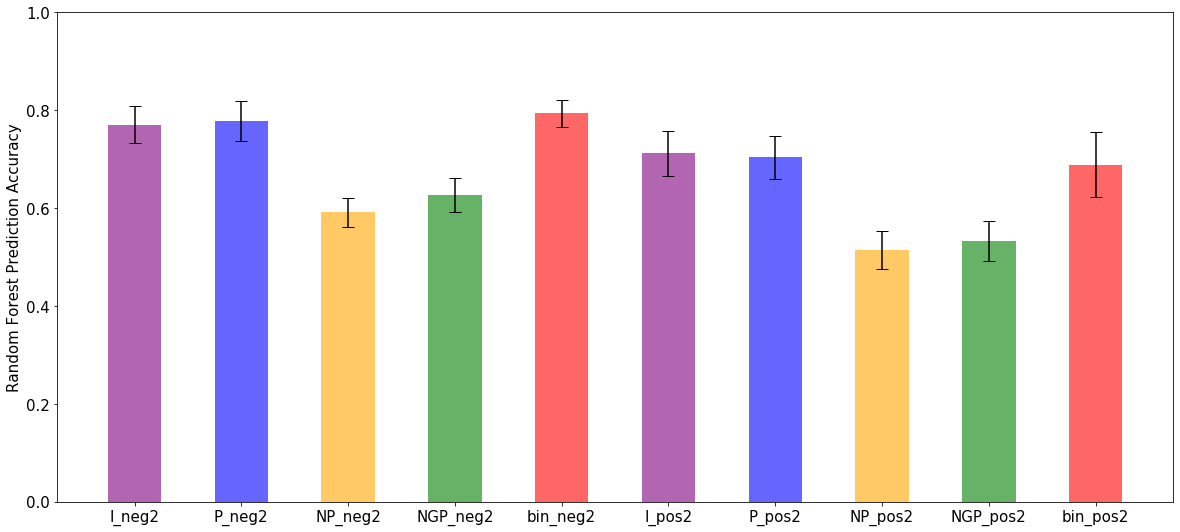

In [122]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][10:], x = Teste_H.columns[10:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[10:], y = Teste_H.T['Accuracy'][10:], yerr = Teste_std_H.iloc[0,10:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated n times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weigth) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function `simple_RF` from multianalysis.

In [123]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

In [124]:
part = {}

part['P_neg'] = treat_neg['P']
part['P_pos'] = treat_pos['P']
part['P_neg2'] = treat_neg2['P']
part['P_pos2'] = treat_pos2['P']
part['bin_neg'] = treat_neg['binary']
part['bin_pos'] = treat_pos['binary']
part['bin_neg2'] = treat_neg2['binary']
part['bin_pos2'] = treat_pos2['binary']

In [125]:
for name, data in part.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)#, iter_num = 100)
    Scores[name] = np.mean(rf)
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done') 

Fitting random forest for P_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for bin_neg ...done
Fitting random forest for bin_pos ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for bin_pos2 ...done


### Attempt/Method nº2 - SMOTE - Code in markdown, not relevant anymore - maybe take out in next version?

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function fast_SMOTE from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
#Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
#glog_S_neg = sca.glog(Norm_S_neg)
Euc_P_S_neg = sca.ParetoScal(Imp_S_neg)#glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
#Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
#glog_S_neg2 = sca.glog(Norm_S_neg2)
Euc_P_S_neg2 = sca.ParetoScal(Imp_S_neg2)#glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
#Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
#glog_S_pos = sca.glog(Norm_S_pos)
Euc_P_S_pos = sca.ParetoScal(Imp_S_pos)#glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
#Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
#glog_S_pos2 = sca.glog(Norm_S_pos2)
Euc_P_S_pos2 = sca.ParetoScal(Imp_S_pos2)#glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

N1_B = ma.simple_RF(Euc_P_S_neg)
Scores['neg1-6_bleed'] = np.mean(N1_B[0])
Scores_std['neg1-6_bleed'] = np.std(N1_B[0])
Imp_feat['neg1-6_bleed'] = N1_B[1]

P1_B = ma.simple_RF(Euc_P_S_pos)
Scores['pos1-6_bleed'] = np.mean(P1_B[0])
Scores_std['pos1-6_bleed'] = np.std(P1_B[0])
Imp_feat['pos1-6_bleed'] = P1_B[1]

N2_B = ma.simple_RF(Euc_P_S_neg2)
Scores['neg1-13_bleed'] = np.mean(N2_B[0])
Scores_std['neg1-13_bleed'] = np.std(N2_B[0])
Imp_feat['neg1-13_bleed'] = N2_B[1]

P2_B = ma.simple_RF(Euc_P_S_pos2)
Scores['pos1-13_bleed'] = np.mean(P2_B[0])
Scores_std['pos1-13_bleed'] = np.std(P2_B[0])
Imp_feat['pos1-13_bleed'] = P2_B[1]

BN1_B = ma.simple_RF(binary_S_neg1)
Scores['neg1-6_bin_bleed'] = np.mean(BN1_B[0])
Scores_std['neg1-6_bin_bleed'] = np.std(BN1_B[0])
Imp_feat['neg1-6_bin_bleed'] = BN1_B[1]

BP1_B = ma.simple_RF(binary_S_pos1)
Scores['pos1-6_bin_bleed'] = np.mean(BP1_B[0])
Scores_std['pos1-6_bin_bleed'] = np.std(BP1_B[0])
Imp_feat['pos1-6_bin_bleed'] = BP1_B[1]

BN2_B = ma.simple_RF(binary_S_neg2)
Scores['neg1-13_bin_bleed'] = np.mean(BN2_B[0])
Scores_std['neg1-13_bin_bleed'] = np.std(BN2_B[0])
Imp_feat['neg1-13_bin_bleed'] = BN2_B[1]

BP2_B = ma.simple_RF(binary_S_pos2)
Scores['pos1-13_bin_bleed'] = np.mean(BP2_B[0])
Scores_std['pos1-13_bin_bleed'] = np.std(BP2_B[0])
Imp_feat['pos1-13_bin_bleed'] = BP2_B[1]

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary) - Not relevant anymore
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function RF_M3 from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [126]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

#Inserting blank lines in the DataFrame for better presentation and separation
#Scores_H = pd.concat([Scores_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_H.iloc[:,8:]], axis = 1)
#Scores_std_H = pd.concat([Scores_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_std_H.iloc[:,8:]], 
                        #axis = 1)

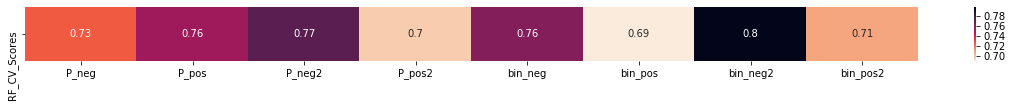

In [127]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
plt.show()

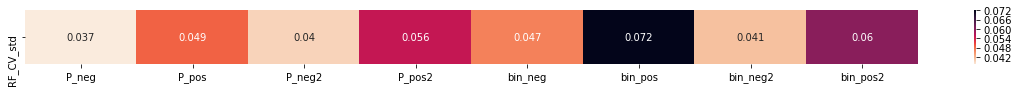

In [128]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 1-6 and 1-13 ("True" Non Bias)

In [129]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [130]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:5], line, df.iloc[5:10], line, df.iloc[10:15], line, df.iloc[15:]])

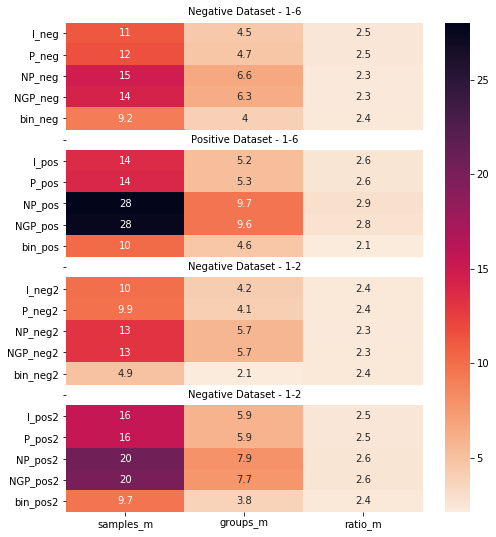

In [131]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,5.5,'Positive Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,11.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,17.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

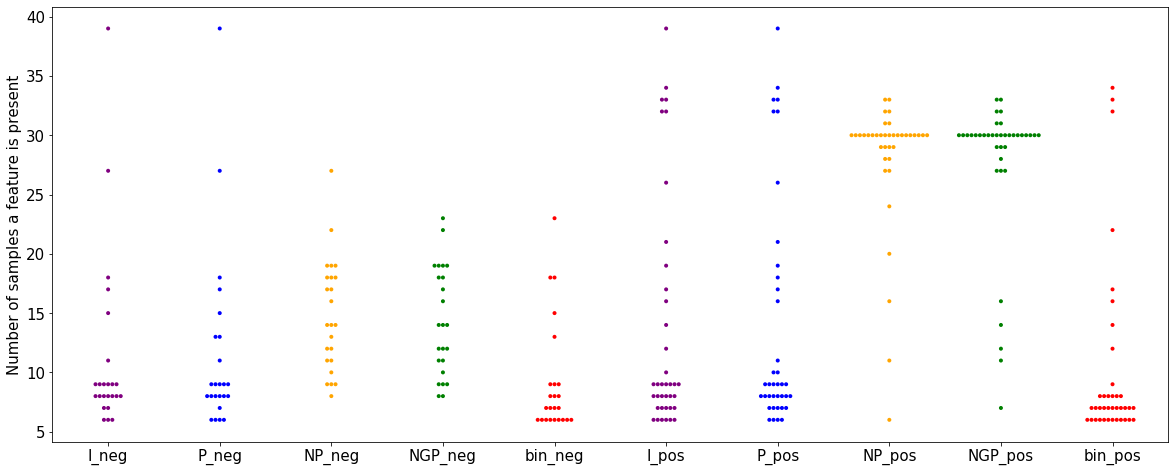

In [132]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:10], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:10])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

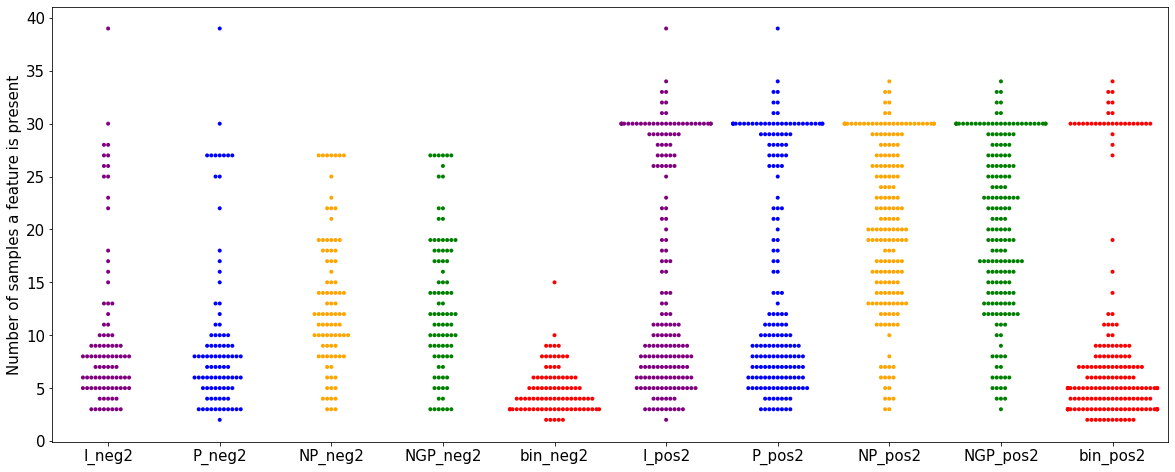

In [133]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[10:], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][10:])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [134]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [4.747342886688236, 4.957389843102293, 3.3795101411409503, 3.201293397666176, 3.5472858038387654, 9.191130524300199, 8.808756995053065, 3.3389405484882078, 3.4060625510819094, 6.6069544840720775, 8.610178444513041, 8.649987011526083, 5.627753962759264, 6.527320958519225, 6.983576787250337, 19.402528616394406, 17.51326900946833, 8.822585856566883, 8.815763812721325, 10.135480735771749]
% of model explained by the 2% most important features [6.523571021680646, 6.482500851506737, 5.098687020281268, 5.139676959018548, 5.245473856086294, 10.247408372541063, 10.335274801109165, 5.861654199764424, 5.875868224830039, 7.661450919964726, 9.090874597055015, 9.109763198404035, 6.938762159523853, 6.968545471290297, 8.16748357278653, 15.58701904320699, 15.87629152712759, 11.021111068922638, 10.8657169942901, 11.561732482872506]


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [135]:
matrix = pd.get_dummies(all_labels)
matrix = matrix[['CAN','CS','LAB','PN','REG','RIP','RL','ROT','RU','TRI','CFN','CHT','SB']]

## Alignment 1-6

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [136]:
%%capture
#PLS applied in the negative dataset.
P_neg_PLS = ma.optim_PLS(P_neg, matrix, max_comp = 50)
NP_neg_PLS = ma.optim_PLS(NP_neg, matrix, max_comp = 50)
NGP_neg_PLS = ma.optim_PLS(NGP_neg, matrix, max_comp = 50)
bin_neg_PLS = ma.optim_PLS(aligned_neg, matrix, max_comp = 50)

#PLS applied in the positive dataset.
P_pos_PLS = ma.optim_PLS(P_pos, matrix, max_comp = 50)
NP_pos_PLS = ma.optim_PLS(NP_pos, matrix, max_comp = 50)
NGP_pos_PLS = ma.optim_PLS(NGP_pos, matrix, max_comp = 50)
bin_pos_PLS = ma.optim_PLS(aligned_pos, matrix, max_comp = 50)

Performance based on number of components - Alignment: 1-6, Negative Mode


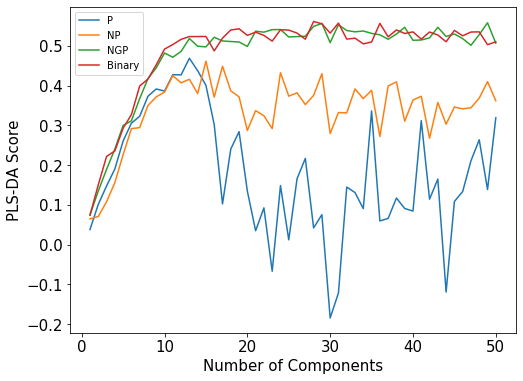

In [137]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS[0])
plt.plot(range(1,51),NP_neg_PLS[0])
plt.plot(range(1,51),NGP_neg_PLS[0])
plt.plot(range(1,51),bin_neg_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-6, Negative Mode')

Performance based on number of components - Alignment: 1-6, Negative Mode


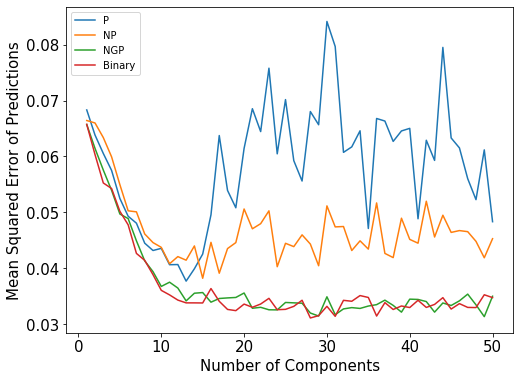

In [138]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS[2])
plt.plot(range(1,51),NP_neg_PLS[2])
plt.plot(range(1,51),NGP_neg_PLS[2])
plt.plot(range(1,51),bin_neg_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-6, Negative Mode')

Performance based on number of components - Alignment: 1-6, Negative Mode


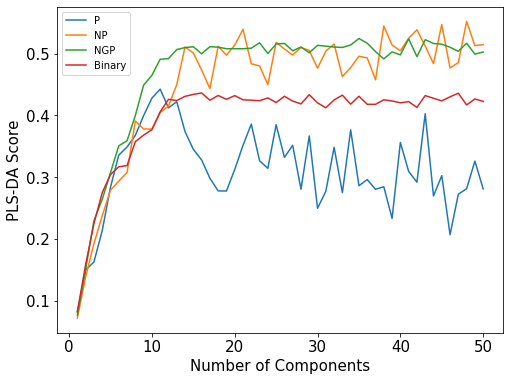

In [139]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS[0])
plt.plot(range(1,51),NP_pos_PLS[0])
plt.plot(range(1,51),NGP_pos_PLS[0])
plt.plot(range(1,51),bin_pos_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-6, Negative Mode')

Performance based on number of components - Alignment: 1-6, Negative Mode


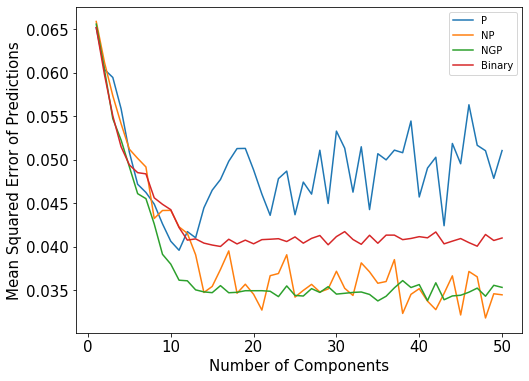

In [140]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS[2])
plt.plot(range(1,51),NP_pos_PLS[2])
plt.plot(range(1,51),NGP_pos_PLS[2])
plt.plot(range(1,51),bin_pos_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-6, Negative Mode')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [141]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [142]:
%%capture
P_neg_PLS = ma.model_PLSDA(P_neg, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_Feat['P_neg'] = P_neg_PLS[3]

NP_neg_PLS = ma.model_PLSDA(NP_neg, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NP_neg'] = NP_neg_PLS[0]
PLS_score['NP_neg'] = NP_neg_PLS[1]
PLS_Feat['NP_neg'] = NP_neg_PLS[3]

NGP_neg_PLS = ma.model_PLSDA(NGP_neg, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_Feat['NGP_neg'] = NGP_neg_PLS[3]

bin_neg_PLS = ma.model_PLSDA(aligned_neg, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_Feat['bin_neg'] = bin_neg_PLS[3]

In [143]:
%%capture
P_pos_PLS = ma.model_PLSDA(P_pos, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_pos'] = P_pos_PLS[0]
PLS_score['P_pos'] = P_pos_PLS[1]
PLS_Feat['P_pos'] = P_pos_PLS[3]

NP_pos_PLS = ma.model_PLSDA(NP_pos, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NP_pos'] = NP_pos_PLS[0]
PLS_score['NP_pos'] = NP_pos_PLS[1]
PLS_Feat['NP_pos'] = NP_pos_PLS[3]

NGP_pos_PLS = ma.model_PLSDA(NGP_pos, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_pos'] = NGP_pos_PLS[0]
PLS_score['NGP_pos'] = NGP_pos_PLS[1]
PLS_Feat['NGP_pos'] = NGP_pos_PLS[3]

bin_pos_PLS = ma.model_PLSDA(aligned_pos, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_pos'] = bin_pos_PLS[0]
PLS_score['bin_pos'] = bin_pos_PLS[1]
PLS_Feat['bin_pos'] = bin_pos_PLS[3]

Accuracy based on the dataset - Alignment: 1-6, Negative and Positive Mode


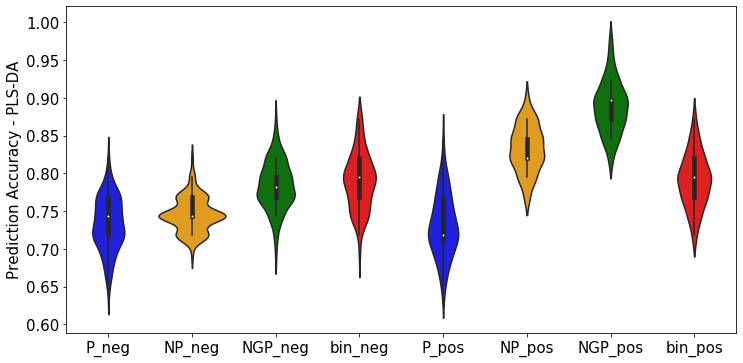

In [144]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['blue','orange','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset - Alignment: 1-6, Negative and Positive Mode')

Performance score based on the dataset - Alignment: 1-6, Negative and Positive Mode


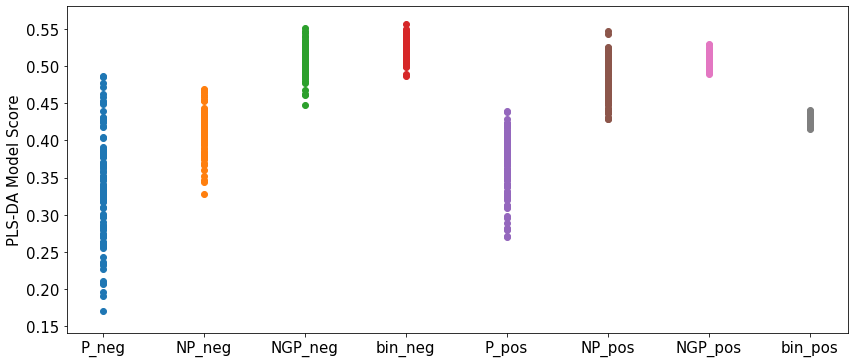

In [145]:
f, ax = plt.subplots(figsize=(14,6))
plt.scatter(['P_neg']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NP_neg']*len(PLS_score['NP_neg']), PLS_score['NP_neg'])
plt.scatter(['NGP_neg']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
plt.scatter(['P_pos']*len(PLS_score['P_pos']), PLS_score['P_pos'])
plt.scatter(['NP_pos']*len(PLS_score['NP_pos']), PLS_score['NP_pos'])
plt.scatter(['NGP_pos']*len(PLS_score['NGP_pos']), PLS_score['NGP_pos'])
plt.scatter(['bin_pos']*len(PLS_score['bin_pos']), PLS_score['bin_pos'])
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance score based on the dataset - Alignment: 1-6, Negative and Positive Mode')

In [146]:
Accuracy = {}
Accuracy['P_neg'] = np.mean(PLS_accu['P_neg'])
Accuracy['NP_neg'] = np.mean(PLS_accu['NP_neg'])
Accuracy['NGP_neg'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg'] = np.mean(PLS_accu['bin_neg'])
Accuracy['P_pos'] = np.mean(PLS_accu['P_pos'])
Accuracy['NP_pos'] = np.mean(PLS_accu['NP_pos'])
Accuracy['NGP_pos'] = np.mean(PLS_accu['NGP_pos'])
Accuracy['bin_pos'] = np.mean(PLS_accu['bin_pos'])

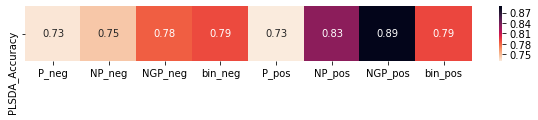

In [147]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [148]:
Score = {}
Score['P_neg'] = np.mean(PLS_score['P_neg'])
Score['NP_neg'] = np.mean(PLS_score['NP_neg'])
Score['NGP_neg'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg'] = np.mean(PLS_score['bin_neg'])
Score['P_pos'] = np.mean(PLS_score['P_pos'])
Score['NP_pos'] = np.mean(PLS_score['NP_pos'])
Score['NGP_pos'] = np.mean(PLS_score['NGP_pos'])
Score['bin_pos'] = np.mean(PLS_score['bin_pos'])

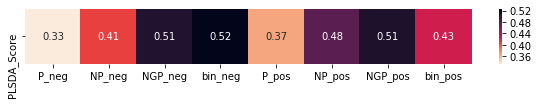

In [149]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [150]:
Accuracy_std = {}
Accuracy_std['P_neg'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NP_neg'] = np.std(PLS_accu['NP_neg'])
Accuracy_std['NGP_neg'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg'] = np.std(PLS_accu['bin_neg'])
Accuracy_std['P_pos'] = np.std(PLS_accu['P_pos'])
Accuracy_std['NP_pos'] = np.std(PLS_accu['NP_pos'])
Accuracy_std['NGP_pos'] = np.std(PLS_accu['NGP_pos'])
Accuracy_std['bin_pos'] = np.std(PLS_accu['bin_pos'])

In [151]:
Score_std = {}
Score_std['P_neg'] = np.std(PLS_score['P_neg'])
Score_std['NP_neg'] = np.std(PLS_score['NP_neg'])
Score_std['NGP_neg'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg'] = np.std(PLS_score['bin_neg'])
Score_std['P_pos'] = np.std(PLS_score['P_pos'])
Score_std['NP_pos'] = np.std(PLS_score['NP_pos'])
Score_std['NGP_pos'] = np.std(PLS_score['NGP_pos'])
Score_std['bin_pos'] = np.std(PLS_score['bin_pos'])

In [152]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

Accuracy        SD
P_neg    0.733333  0.034781
NP_neg   0.745897  0.022086
NGP_neg  0.784103  0.031441
bin_neg  0.790256  0.037225
P_pos    0.731026  0.040460
NP_pos   0.832821  0.030658
NGP_pos  0.888205  0.033924
bin_pos  0.791282  0.034973

In [153]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

Score        SD
P_neg    0.334553  0.072298
NP_neg   0.410531  0.027718
NGP_neg  0.507673  0.018521
bin_neg  0.524438  0.013996
P_pos    0.368063  0.039952
NP_pos   0.479588  0.026932
NGP_pos  0.509743  0.007848
bin_pos  0.426940  0.005362

### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [154]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_Feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    
    imp_features = PLS_Feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [155]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

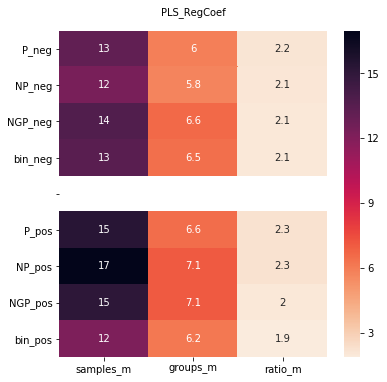

In [156]:
f, ax = plt.subplots(figsize=(6, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

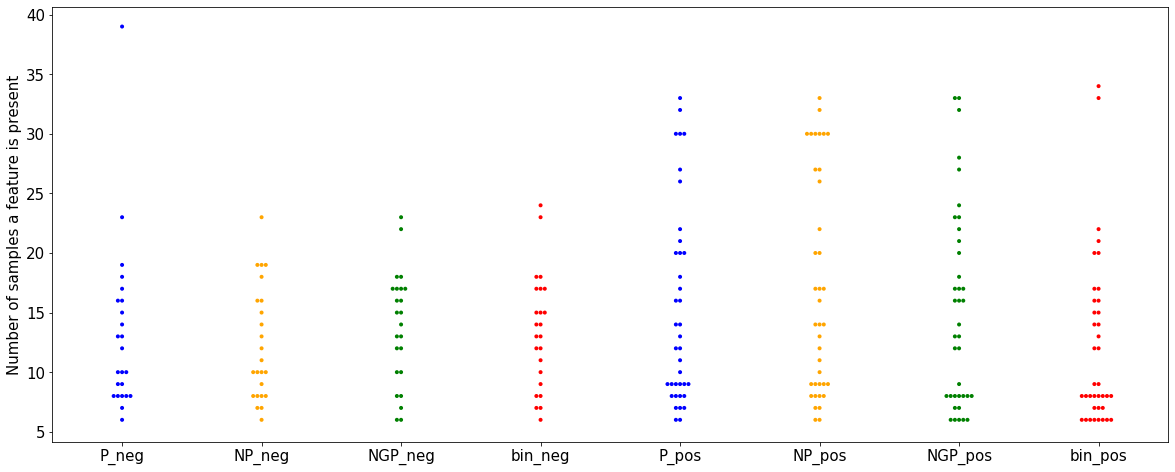

In [157]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_Feat.keys())[i] for i in range(len(PLS_Feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [158]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[9.199365032135562, 11.765885950006329, 6.139411941442723, 3.6029573094390117, 17.123800464375673, 8.127541051999362, 5.286237592996649, 4.221472856834892]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [159]:
from sklearn.cross_decomposition import PLSRegression

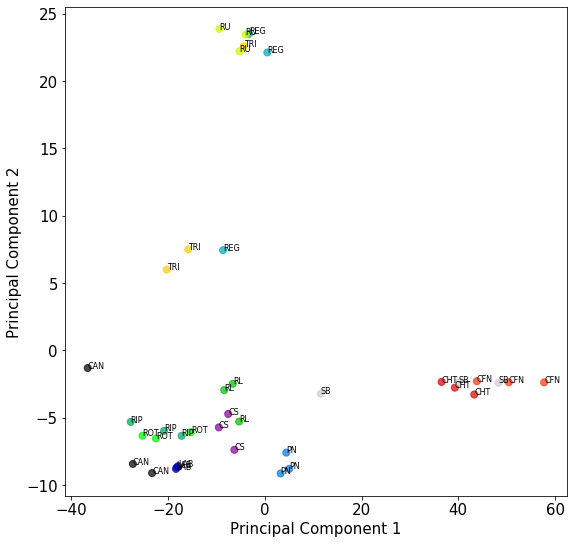

In [160]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_neg.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = NGP_neg.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

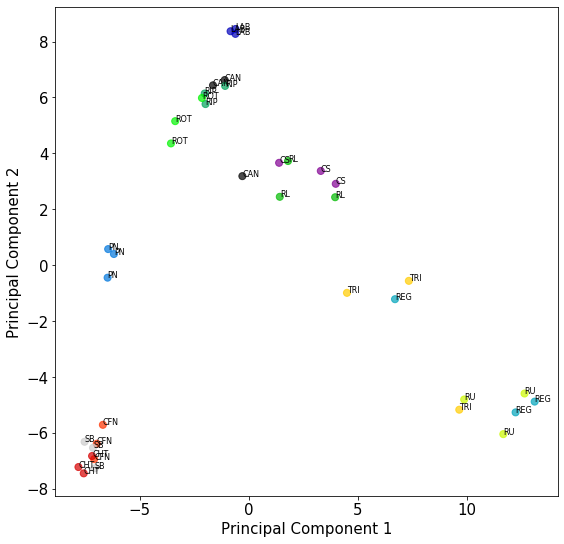

In [161]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=aligned_neg.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = aligned_neg.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

## Alignment 1-13

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [162]:
%%capture
#PLS applied in the negative dataset.
P_neg_PLS = ma.optim_PLS(P_neg2, matrix, max_comp = 50)
NP_neg_PLS = ma.optim_PLS(NP_neg2, matrix, max_comp = 50)
NGP_neg_PLS = ma.optim_PLS(NGP_neg2, matrix, max_comp = 50)
bin_neg_PLS = ma.optim_PLS(aligned_neg2, matrix, max_comp = 50)

#PLS applied in the positive dataset.
P_pos_PLS = ma.optim_PLS(P_pos2, matrix, max_comp = 50)
NP_pos_PLS = ma.optim_PLS(NP_pos2, matrix, max_comp = 50)
NGP_pos_PLS = ma.optim_PLS(NGP_pos2, matrix, max_comp = 50)
bin_pos_PLS = ma.optim_PLS(aligned_pos2, matrix, max_comp = 50)

Performance based on number of components - Alignment: 1-2, Negative Mode


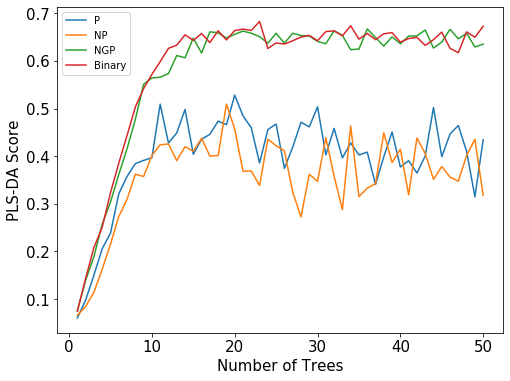

In [163]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_neg_PLS[0])
plt.plot(range(1,51),NP_neg_PLS[0])
plt.plot(range(1,51),NGP_neg_PLS[0])
plt.plot(range(1,51),bin_neg_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-2, Negative Mode')

Performance based on number of components - Alignment: 1-2, Positive Mode


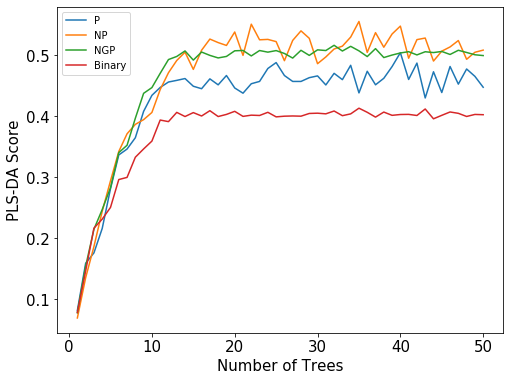

In [164]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,51),P_pos_PLS[0])
plt.plot(range(1,51),NP_pos_PLS[0])
plt.plot(range(1,51),NGP_pos_PLS[0])
plt.plot(range(1,51),bin_pos_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components - Alignment: 1-2, Positive Mode')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [165]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [166]:
%%capture
P_neg_PLS = ma.model_PLSDA(P_neg2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_Feat['P_neg'] = P_neg_PLS[3]

NP_neg_PLS = ma.model_PLSDA(NP_neg2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NP_neg'] = NP_neg_PLS[0]
PLS_score['NP_neg'] = NP_neg_PLS[1]
PLS_Feat['NP_neg'] = NP_neg_PLS[3]

NGP_neg_PLS = ma.model_PLSDA(NGP_neg2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_Feat['NGP_neg'] = NGP_neg_PLS[3]

bin_neg_PLS = ma.model_PLSDA(aligned_neg2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_Feat['bin_neg'] = bin_neg_PLS[3]

In [167]:
%%capture
P_pos_PLS = ma.model_PLSDA(P_pos2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_pos'] = P_pos_PLS[0]
PLS_score['P_pos'] = P_pos_PLS[1]
PLS_Feat['P_pos'] = P_pos_PLS[3]

NP_pos_PLS = ma.model_PLSDA(NP_pos2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NP_pos'] = NP_pos_PLS[0]
PLS_score['NP_pos'] = NP_pos_PLS[1]
PLS_Feat['NP_pos'] = NP_pos_PLS[3]

NGP_pos_PLS = ma.model_PLSDA(NGP_pos2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_pos'] = NGP_pos_PLS[0]
PLS_score['NGP_pos'] = NGP_pos_PLS[1]
PLS_Feat['NGP_pos'] = NGP_pos_PLS[3]

bin_pos_PLS = ma.model_PLSDA(aligned_pos2, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_pos'] = bin_pos_PLS[0]
PLS_score['bin_pos'] = bin_pos_PLS[1]
PLS_Feat['bin_pos'] = bin_pos_PLS[3]

Accuracy based on the dataset - Alignment: 1-2, Negative and Positive Mode


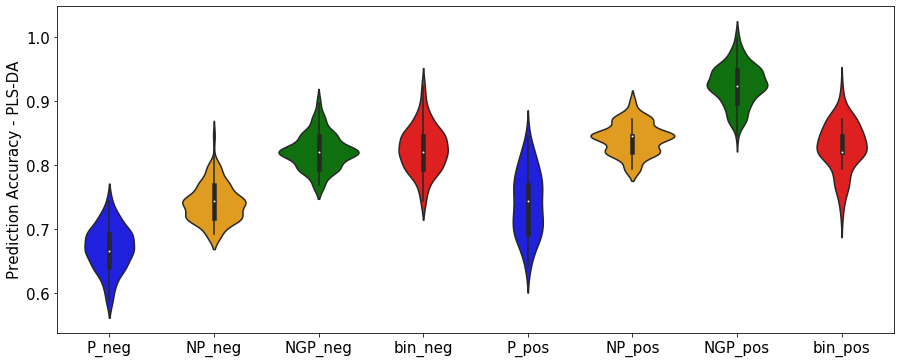

In [168]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Accuracy based on the dataset - Alignment: 1-2, Negative and Positive Mode')

Performance score based on the dataset - Alignment: 1-2, Negative and Positive Mode


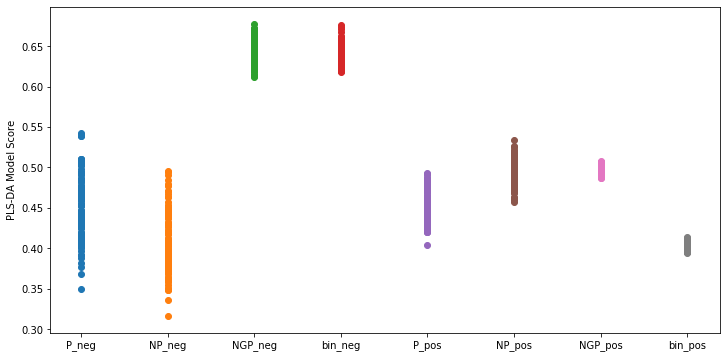

In [169]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['P_neg']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NP_neg']*len(PLS_score['NP_neg']), PLS_score['NP_neg'])
plt.scatter(['NGP_neg']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
plt.scatter(['P_pos']*len(PLS_score['P_pos']), PLS_score['P_pos'])
plt.scatter(['NP_pos']*len(PLS_score['NP_pos']), PLS_score['NP_pos'])
plt.scatter(['NGP_pos']*len(PLS_score['NGP_pos']), PLS_score['NGP_pos'])
plt.scatter(['bin_pos']*len(PLS_score['bin_pos']), PLS_score['bin_pos'])
plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset - Alignment: 1-2, Negative and Positive Mode')

In [170]:
Accuracy = {}
Accuracy['P_neg'] = np.mean(PLS_accu['P_neg'])
Accuracy['NP_neg'] = np.mean(PLS_accu['NP_neg'])
Accuracy['NGP_neg'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg'] = np.mean(PLS_accu['bin_neg'])
Accuracy['P_pos'] = np.mean(PLS_accu['P_pos'])
Accuracy['NP_pos'] = np.mean(PLS_accu['NP_pos'])
Accuracy['NGP_pos'] = np.mean(PLS_accu['NGP_pos'])
Accuracy['bin_pos'] = np.mean(PLS_accu['bin_pos'])

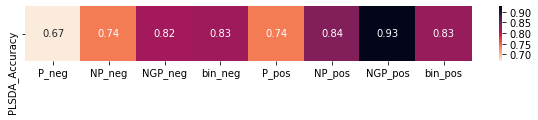

In [171]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [172]:
Score = {}
Score['P_neg'] = np.mean(PLS_score['P_neg'])
Score['NP_neg'] = np.mean(PLS_score['NP_neg'])
Score['NGP_neg'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg'] = np.mean(PLS_score['bin_neg'])
Score['P_pos'] = np.mean(PLS_score['P_pos'])
Score['NP_pos'] = np.mean(PLS_score['NP_pos'])
Score['NGP_pos'] = np.mean(PLS_score['NGP_pos'])
Score['bin_pos'] = np.mean(PLS_score['bin_pos'])

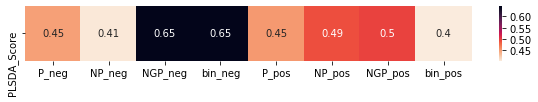

In [173]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [174]:
Accuracy_std = {}
Accuracy_std['P_neg'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NP_neg'] = np.std(PLS_accu['NP_neg'])
Accuracy_std['NGP_neg'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg'] = np.std(PLS_accu['bin_neg'])
Accuracy_std['P_pos'] = np.std(PLS_accu['P_pos'])
Accuracy_std['NP_pos'] = np.std(PLS_accu['NP_pos'])
Accuracy_std['NGP_pos'] = np.std(PLS_accu['NGP_pos'])
Accuracy_std['bin_pos'] = np.std(PLS_accu['bin_pos'])

In [175]:
Score_std = {}
Score_std['P_neg'] = np.std(PLS_score['P_neg'])
Score_std['NP_neg'] = np.std(PLS_score['NP_neg'])
Score_std['NGP_neg'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg'] = np.std(PLS_score['bin_neg'])
Score_std['P_pos'] = np.std(PLS_score['P_pos'])
Score_std['NP_pos'] = np.std(PLS_score['NP_pos'])
Score_std['NGP_pos'] = np.std(PLS_score['NGP_pos'])
Score_std['bin_pos'] = np.std(PLS_score['bin_pos'])

In [176]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

Accuracy        SD
P_neg    0.670513  0.034663
NP_neg   0.741026  0.028896
NGP_neg  0.821795  0.026984
bin_neg  0.825641  0.035714
P_pos    0.741026  0.049521
NP_pos   0.841795  0.024068
NGP_pos  0.925641  0.030876
bin_pos  0.829231  0.037723

In [177]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

Score        SD
P_neg    0.450534  0.040268
NP_neg   0.406266  0.037307
NGP_neg  0.645575  0.015727
bin_neg  0.645042  0.012067
P_pos    0.454309  0.019636
NP_pos   0.493409  0.015892
NGP_pos  0.498587  0.004565
bin_pos  0.403714  0.004001

### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [178]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_Feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        Spectra = aligned_all_neg2
    elif name.endswith('pos'):
        Spectra = aligned_all_pos2
    
    imp_features = PLS_Feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [179]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

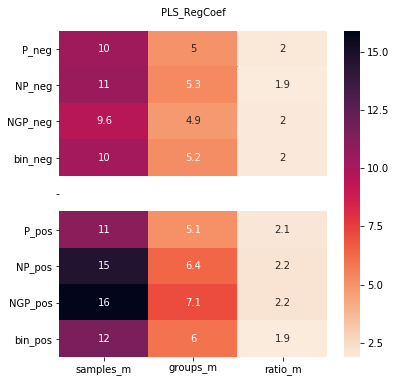

In [180]:
f, ax = plt.subplots(figsize=(6, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

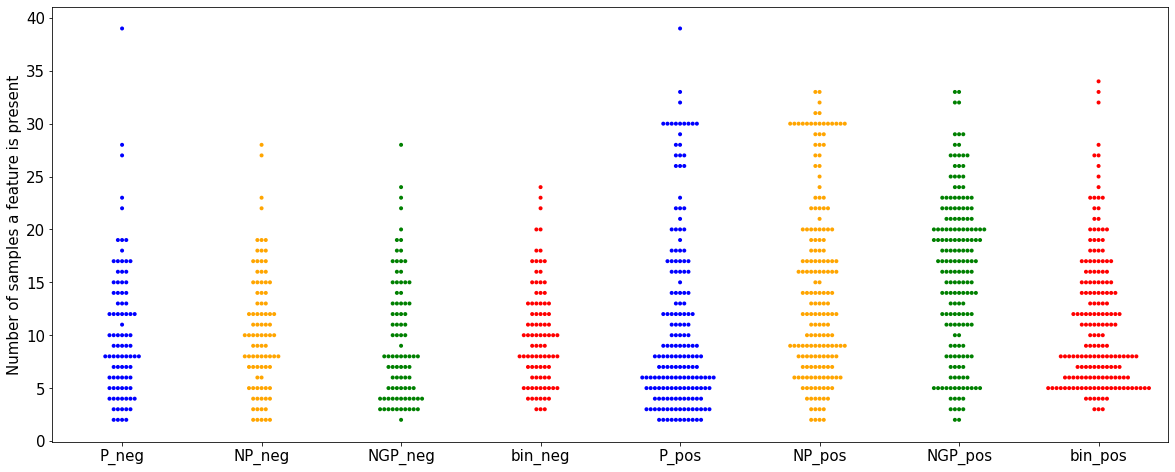

In [200]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_Feat.keys())[i] for i in range(len(PLS_Feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [182]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[18.17027048764778, 26.68318268352855, 8.30487686063854, 4.627089693249356, 28.581367801952112, 20.31934741172429, 9.366498674136935, 4.790420742712851]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [183]:
from sklearn.cross_decomposition import PLSRegression

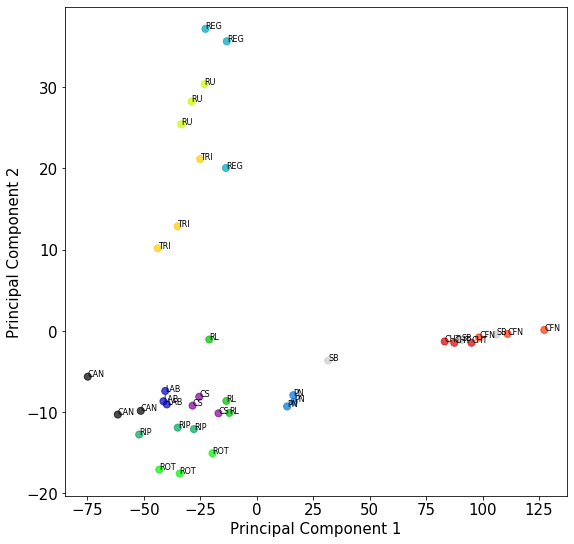

In [184]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

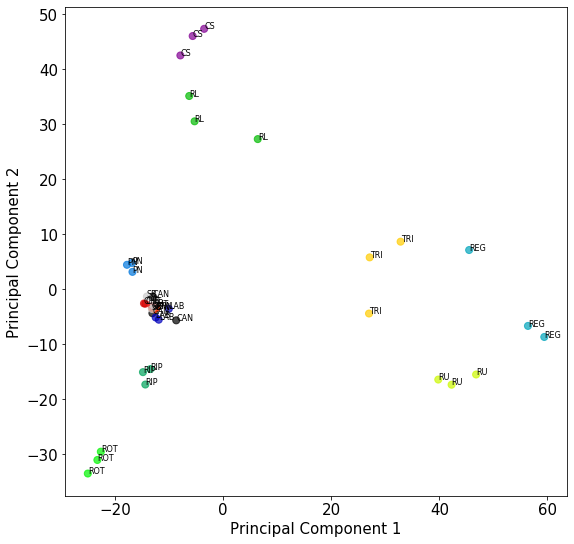

In [185]:
plsda = PLSRegression(n_components = 15)
#Fitting the model and getting the X_scores
plsda.fit(X=aligned_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function permutation_RF in multianalysis.py

In [186]:
CV = {}
PMs = {}
pvalue = {}

In [187]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NP_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NP_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for bin_pos ...
Done!
Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for bin_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for bin_pos2 ...
Done!


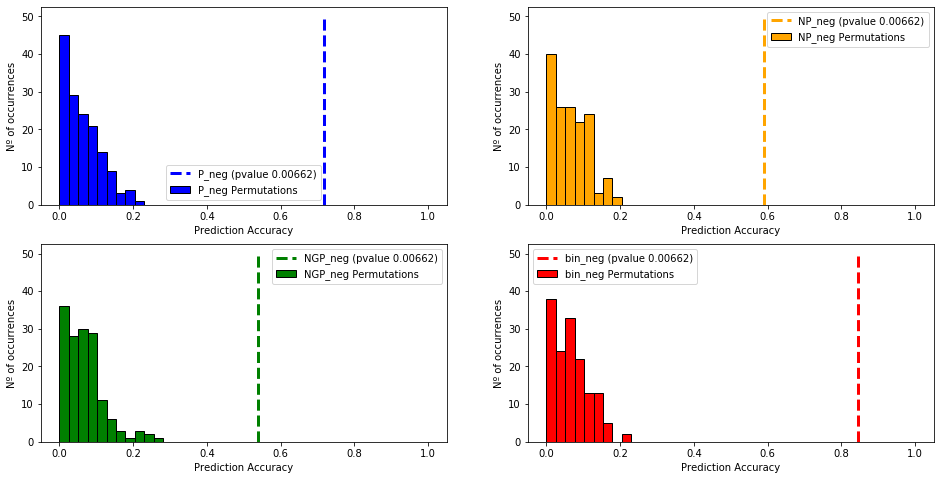

In [189]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

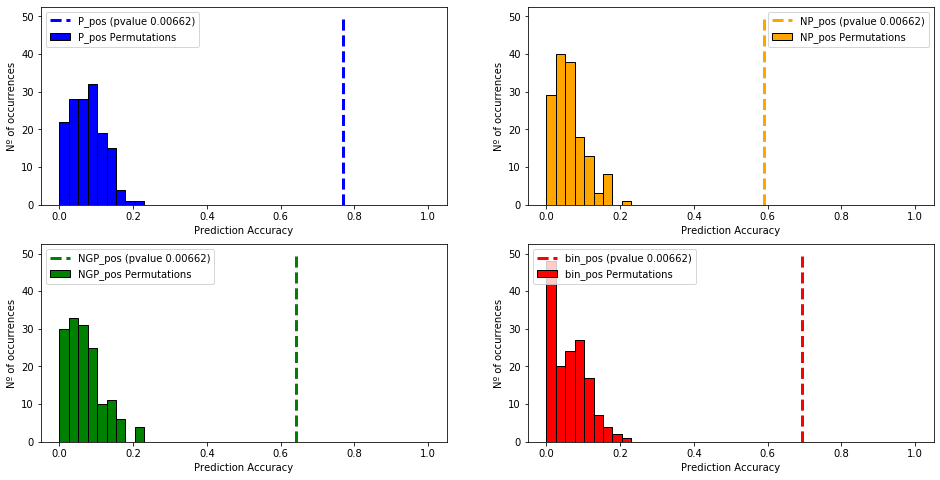

In [190]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

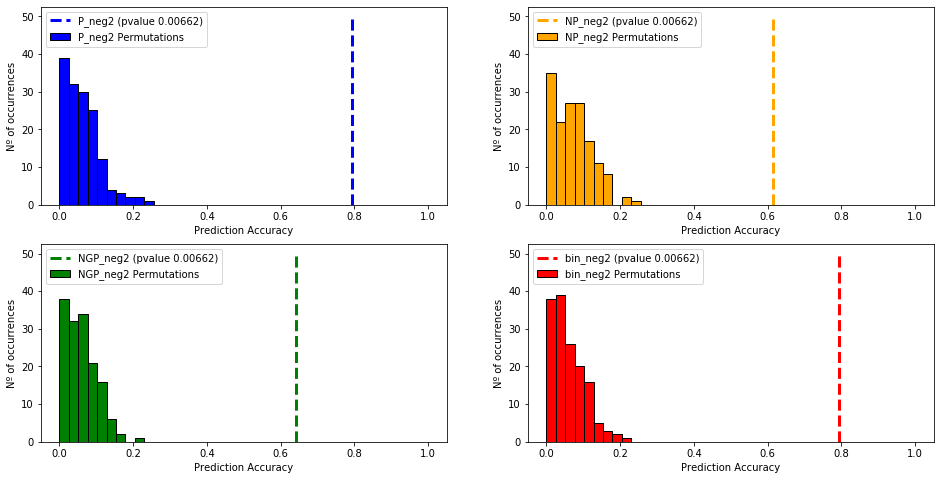

In [191]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

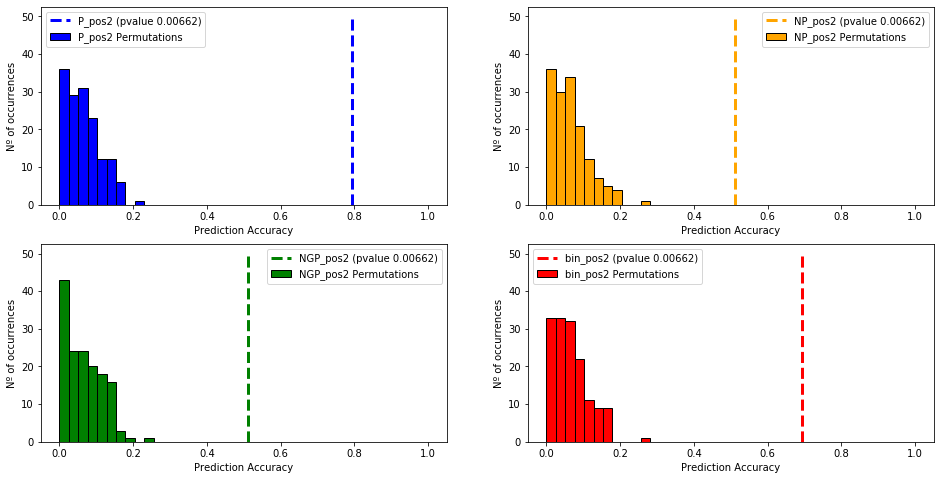

In [192]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [193]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [194]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=6, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NP_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...
Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NP_pos ...
Done!
permutation test (PLS-DA) for NGP_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos ...
Done!
permutation test (PLS-DA) for P_neg2 ...
Done!
permutation test (PLS-DA) for NP_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP_neg2 ...
Done!
permutation test (PLS-DA) for bin_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos2 ...
Done!


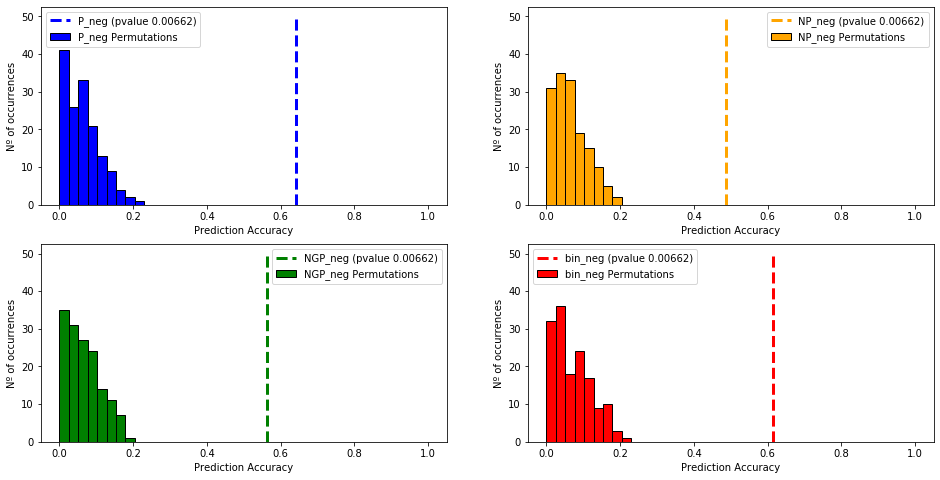

In [195]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

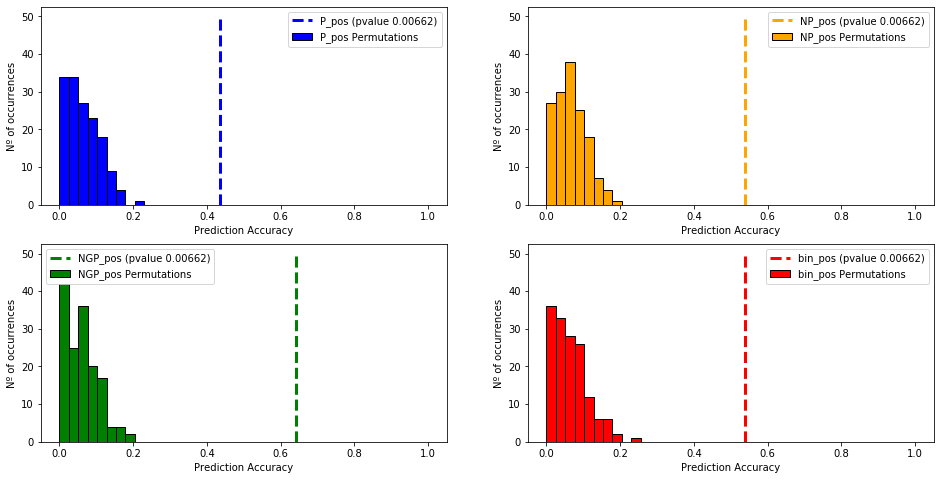

In [196]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

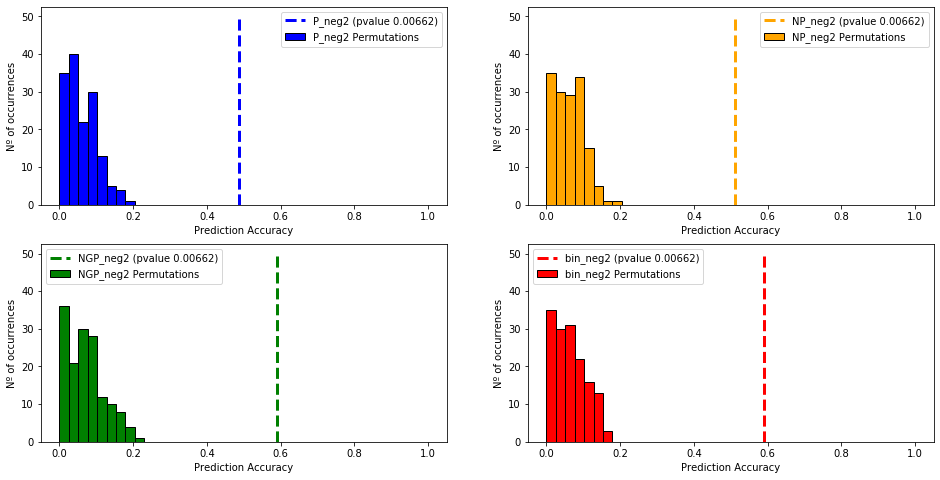

In [197]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

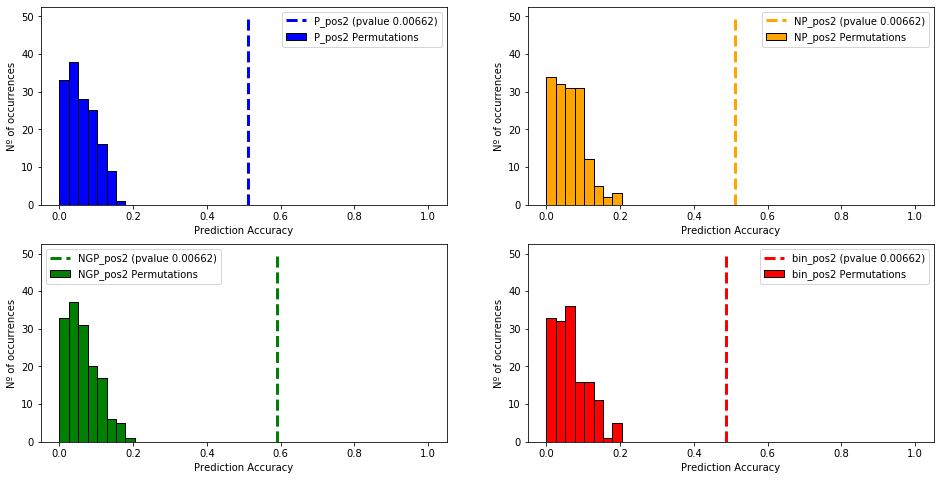

In [198]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Other things

In [199]:
#matrix = pd.DataFrame(np.zeros((39,13)))
#for i in range(13):
#    matrix.iloc[3*i:3*i+3,i] = 1

from sklearn.model_selection import KFold, StratifiedKFold
CVs = []
CVr2s = []
MSEs = []

for i in range(1,50):
    cv = []
    cvr2 = []
    mse = []
    kf = StratifiedKFold(3, shuffle = True)
    for train_index, test_index in kf.split(Euc_NGP_neg2.data.T, Euc_NGP_neg2.labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
        plsda = PLSRegression(n_components = i)
        #plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
        X_train, X_test = Euc_NGP_neg2.data[Euc_P_neg2.data.columns[train_index]].T, Euc_NGP_neg2.data[Euc_P_neg.data.columns[test_index]].T
        y_train, y_test = matrix.T[matrix.T.columns[train_index]].T, matrix.T[matrix.T.columns[test_index]].T
        plsda.fit(X=X_train,Y=y_train)
        cv.append(plsda.score(X_test,y_test))
        cvr2.append(r2_score(plsda.predict(X_test), y_test))
        y_pred = plsda.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))
    CVs.append(np.mean(cv))
    CVr2s.append(np.mean(cvr2))
    MSEs.append(np.mean(mse))

f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,50),CVs)

plsda = PLSRegression(n_components = 25)
plsda.fit(X=Euc_NGP_neg2.data.T,Y=matrix)

cv = []
cvr2 = []
mse = []
kf = StratifiedKFold(3, shuffle = True)
certo = 0
for train_index, test_index in kf.split(Euc_NGP_neg2.data.T, Euc_NGP_neg2.labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
    plsda = PLSRegression(n_components = 25)
    #plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
    X_train, X_test = Euc_NGP_neg2.data[Euc_NGP_neg2.data.columns[train_index]].T, Euc_NGP_neg2.data[Euc_NGP_neg2.data.columns[test_index]].T
    y_train, y_test = matrix.T[matrix.T.columns[train_index]].T, matrix.T[matrix.T.columns[test_index]].T
    plsda.fit(X=X_train,Y=y_train)
    cv.append(plsda.score(X_test,y_test))
    cvr2.append(r2_score(plsda.predict(X_test), y_test))
    y_pred = plsda.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    for i in range(len(y_pred)):
        if list(y_test[i]).index(max(y_test[i])) == np.argmax(y_pred[i]):
            certo = certo + 1
print(certo/len(Euc_NGP_neg.labels))